In [20]:
import xgboost as xgb
import json, logging
import numpy as np
import pandas as pd
import optuna
import joblib
from pathlib import Path
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [ ]:
NOTEBOOK_NAME = "MIPLIB-XGBoost-SurvivalAnalysis"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="xgb_runtime_model"):
    model_path = RUN_DIR / "model" / f"{name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")


def save_optuna(study):
    joblib.dump(study, RUN_DIR / "optuna" / "study.pkl")
    trials_df = study.trials_dataframe()
    trials_df.to_csv(RUN_DIR / "optuna" / "trials.csv", index=False)
    with open(RUN_DIR / "optuna" / "best_params.json", "w") as f:
        json.dump(study.best_params, f, indent=2)
    print("Optuna study & best params stored")


def save_metrics(name: str, value):
    with open(RUN_DIR / "metrics" / f"{name}.json", "w") as f:
        json.dump(value, f, indent=2)

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [21]:
def plot_calibration_on_solved_cases(
    true_log, pred_log,
    save_path=None, show=False,
    lower=1e-4, upper=1e4,
    figsize=(6, 6), dpi=150,
    title="True vs. Predicted runtime"
):
    true_log = np.asarray(true_log, float)
    pred_log = np.asarray(pred_log, float)
    msk = np.isfinite(true_log) & np.isfinite(pred_log)
    t_log, p_log = true_log[msk], pred_log[msk]

    t_sec = np.power(10.0, t_log)
    p_sec = np.power(10.0, p_log)

    # inside/outside plotting range
    inside = (p_sec >= lower) & (p_sec <= upper)
    p_sec_clip = np.clip(p_sec, lower, upper)

    # figure
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.set_xscale("log"); ax.set_yscale("log")

    # points
    ax.scatter(t_sec[inside],  p_sec[inside],  s=18, alpha=0.6, edgecolor="none")
    ax.scatter(t_sec[~inside], p_sec_clip[~inside], s=18, alpha=0.6, marker="x")

    # red dashed diagonal
    ax.plot([lower, upper], [lower, upper], linestyle="--", linewidth=1.0, color="red")

    # axes, ticks, labels
    ax.set_xlim(lower, upper); ax.set_ylim(lower, upper)
    tick_vals = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
    tick_lbls = [fr"$10^{{{int(np.log10(t))}}}$" for t in tick_vals]
    ax.set_xticks(tick_vals, tick_lbls); ax.set_yticks(tick_vals, tick_lbls)

    ax.set_xlabel("true runtime (s)")
    ax.set_ylabel("predicted runtime (s)")
    ax.set_title(title)
    ax.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
    plt.tight_layout()

    # save/close
    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=dpi)
    if show:
        plt.show(block=False)
    else:
        plt.close(fig)


In [22]:
def plot_aggregated_learning_curves(nll_histories, cidx_histories,
                                    save_path=None, show=False, dpi=150):
    """
    Aggregates live curves across folds.
    Plots mean (solid) and ±1 SD (shaded) over boosting iterations for:
      - aft-nloglik on the left
      - validation C-index on the right
    """
    def _pad_to_matrix(list_of_lists):
        max_len = max(len(h) for h in list_of_lists)
        M = np.full((len(list_of_lists), max_len), np.nan, dtype=float)
        for i, h in enumerate(list_of_lists):
            M[i, :len(h)] = np.asarray(h, float)
        return M

    nll_M  = _pad_to_matrix(nll_histories)
    cidx_M = _pad_to_matrix(cidx_histories)

    x      = np.arange(1, nll_M.shape[1] + 1)
    nll_mu = np.nanmean(nll_M, axis=0)
    nll_sd = np.nanstd(nll_M,  axis=0)

    x2      = np.arange(1, cidx_M.shape[1] + 1)
    cidx_mu = np.nanmean(cidx_M, axis=0)
    cidx_sd = np.nanstd(cidx_M,  axis=0)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi=dpi)

    ax1.plot(x, nll_mu, label="aft-nloglik")
    ax1.fill_between(x, nll_mu - nll_sd, nll_mu + nll_sd, alpha=0.2)
    ax1.set_xlabel("# Boosting Iterations")
    ax1.set_ylabel("aft-nloglik")
    ax1.legend(loc="best")

    ax2.plot(x2, cidx_mu, label="C-index (valid)")
    ax2.fill_between(x2, cidx_mu - cidx_sd, cidx_mu + cidx_sd, alpha=0.2)
    ax2.set_xlabel("# Boosting Iterations")
    ax2.set_ylabel("C-index (valid)")
    ax2.legend(loc="best")

    fig.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, dpi=dpi)

    if show:
        plt.show(block=False)
    else:
        plt.close(fig)

In [23]:
from lifelines.utils import concordance_index

class LiveLearningCurves(xgb.callback.TrainingCallback):
    """
    Live learning curves:
      - left: aft-nloglik (valid if available else train)
      - right: validation C-index (lifelines), updated every `plot_every` rounds
    """
    def __init__(self, dvalid: xgb.DMatrix, ylb_valid: np.ndarray, yub_valid: np.ndarray,
                 plot_every: int = 10, live: bool = True):
        super().__init__()
        self.dvalid = dvalid
        self.ylb_valid = np.asarray(ylb_valid, float)              # durations (sec)
        self.yub_valid = np.asarray(yub_valid, float)              # inf => censored
        self.event_valid = np.isfinite(self.yub_valid).astype(int) # 1=observed, 0=censored
        self.plot_every = plot_every
        self.live = live

        self.nll_hist:  list[float] = []
        self.cidx_hist: list[float] = []

        # figure
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(8, 3))
        (self.nll_line,)  = self.ax1.plot([], [], "o-", label="aft-nloglik")
        (self.cidx_line,) = self.ax2.plot([], [], "o-", label="C-index (valid)")
        self.ax1.set_xlabel("# Boosting Iterations")
        self.ax2.set_xlabel("# Boosting Iterations")
        self.ax1.legend(loc="best")
        self.ax2.legend(loc="best")
        self.fig.tight_layout()
        if self.live:
            plt.ion()
            self.fig.show()

    def after_iteration(self, model: xgb.Booster, epoch: int,
                        evals_log: xgb.callback.TrainingCallback.EvalsLog) -> bool:
        if "valid" in evals_log and "aft-nloglik" in evals_log["valid"]:
            self.nll_hist.append(evals_log["valid"]["aft-nloglik"][-1])
        elif "train" in evals_log and "aft-nloglik" in evals_log["train"]:
            self.nll_hist.append(evals_log["train"]["aft-nloglik"][-1])

        y_pred = model.predict(self.dvalid)  # predicted runtimes (sec)
        try:
            cidx = concordance_index(self.ylb_valid, y_pred, event_observed=self.event_valid)
        except Exception:
            cidx = np.nan
        self.cidx_hist.append(float(cidx))

        if (epoch % self.plot_every) == 0:
            x = np.arange(1, len(self.nll_hist) + 1)
            self.nll_line.set_data(x, self.nll_hist)
            self.ax1.set_xlim(1, max(2, len(self.nll_hist)))

            x2 = np.arange(1, len(self.cidx_hist) + 1)
            self.cidx_line.set_data(x2, self.cidx_hist)
            self.ax2.set_xlim(1, max(2, len(self.cidx_hist)))

            # autoscale y
            for ax, y in [(self.ax1, self.nll_hist), (self.ax2, self.cidx_hist)]:
                if len(y) >= 2:
                    ymin, ymax = np.nanmin(y), np.nanmax(y)
                    pad = 0.05 * (ymax - ymin if ymax > ymin else (ymax or 1.0))
                    ax.set_ylim(ymin - pad, ymax + pad)

            if self.live:
                self.fig.canvas.draw()
                self.fig.canvas.flush_events()
        return False

    def save(self, path):
        self.fig.savefig(path, dpi=130)

    def close(self, path=None):
        if path:
            self.save(path)
        plt.close(self.fig)


In [ ]:
NOTEBOOK_NAME = "MIPLIB-XGBoost-SurvivalAnalysis"

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
RUN_DIR = Path("../results") / f"{timestamp}_{NOTEBOOK_NAME}"
SUBDIRS = ["model", "optuna", "metrics", "logs"]

for sd in SUBDIRS:
    (RUN_DIR / sd).mkdir(parents=True, exist_ok=True)

print(f"All outputs will be saved under: {RUN_DIR.resolve()}")

def save_model(model, name="xgb_runtime_model"):
    model_path = RUN_DIR / "model" / f"{name}.json"
    model.save_model(model_path)
    print(f"Model saved to {model_path}")


def save_optuna(study):
    joblib.dump(study, RUN_DIR / "optuna" / "study.pkl")
    trials_df = study.trials_dataframe()
    trials_df.to_csv(RUN_DIR / "optuna" / "trials.csv", index=False)
    with open(RUN_DIR / "optuna" / "best_params.json", "w") as f:
        json.dump(study.best_params, f, indent=2)
    print("Optuna study & best params stored")


def save_metrics(name: str, value):
    with open(RUN_DIR / "metrics" / f"{name}.json", "w") as f:
        json.dump(value, f, indent=2)

logfile = RUN_DIR / "logs" / "run.log"
logging.basicConfig(filename=logfile, filemode="w",
                    level=logging.INFO,
                    format="%(asctime)s %(levelname)s | %(message)s")
logging.info("Run directory initialised")

In [25]:
df_features = pd.read_csv('data/miplib_hutter_features.csv', header=0)
df_cplex_runtimes = pd.read_csv('/data/miplib_cplex_runtimes.csv')
df_cplex_runtimes["runtime_sec"] = pd.to_numeric(df_cplex_runtimes["runtime_sec"])
df_features.head()

,instance,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,cliqueCuts,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time
0,30n20b8.mps.gz,1,18380.0,576,109706.0,0,0,0,0.451208,8.062840,...,0,0,0,0,0,0.47,0.01,0.00,0.01,4.21
1,2club200v15p5scn.mps.gz,1,200.0,17013,104811.0,0,0,0,0.310556,0.362519,...,0,0,0,0,0,0.30,0.01,0.00,0.02,9.10
2,8div-n59k10.mps.gz,1,6143.0,2065,539151.0,0,0,0,0.242108,9.867550,...,0,0,0,0,0,0.52,0.03,0.01,0.03,4.65
3,22433.mps.gz,1,429.0,198,3408.0,0,0,0,0.117360,0.200469,...,0,0,0,0,0,0.00,0.00,0.00,0.00,10.59
4,10teams.mps.gz,1,2025.0,230,12150.0,0,0,0,0.020263,0.081960,...,0,0,0,0,0,0.02,0.00,0.00,0.00,16.77


In [26]:
df_combined = (
    df_features                         # left table
      .merge(                           # join
          df_cplex_runtimes[["instance", "runtime_sec"]],  # right table (only needed cols)
          on="instance",                # key column
          how="inner"                   # inner = intersection
      )
)
df_combined.head()

,instance,probtype,n_vars,n_constr,n_nzcnt,nq_vars,nq_constr,nq_nzcnt,lp_avg,lp_l2_avg,...,impliedBoundCuts,flowCuts,mixedIntegerRoundingCuts,gomoryFractionalCuts,time_relax,time_VCG0,time_VCG1,time_VCG2,cplex_prob_time,runtime_sec
0,30n20b8.mps.gz,1,18380.0,576,109706.0,0,0,0,0.451208,8.062840,...,0,0,0,0,0.47,0.01,0.00,0.01,4.21,2.13
1,2club200v15p5scn.mps.gz,1,200.0,17013,104811.0,0,0,0,0.310556,0.362519,...,0,0,0,0,0.30,0.01,0.00,0.02,9.10,3608.04
2,8div-n59k10.mps.gz,1,6143.0,2065,539151.0,0,0,0,0.242108,9.867550,...,0,0,0,0,0.52,0.03,0.01,0.03,4.65,3600.22
3,22433.mps.gz,1,429.0,198,3408.0,0,0,0,0.117360,0.200469,...,0,0,0,0,0.00,0.00,0.00,0.00,10.59,0.24
4,10teams.mps.gz,1,2025.0,230,12150.0,0,0,0,0.020263,0.081960,...,0,0,0,0,0.02,0.00,0.00,0.00,16.77,2.92


In [27]:
print(df_combined.shape)

(922, 150)


In [28]:
df_features = df_combined.drop(columns=["runtime_sec"])
TIME_LIMIT = 3600.0
df_cplex_runtimes = df_combined["runtime_sec"].astype(float)

solved = df_cplex_runtimes < TIME_LIMIT
y_lb = np.clip(df_cplex_runtimes, 1e-9, None)
y_ub = np.where(solved, y_lb, np.inf)
df_features.set_index("instance", inplace=True)
df_cplex_runtimes.index = df_features.index

In [30]:
nonconst_mask = df_features.apply(lambda c: c.dropna().nunique() > 1)
df_features = df_features.loc[:, nonconst_mask]

In [31]:
df_features.replace(-512, np.nan, inplace=True)

In [32]:
X = df_features
runtimes = df_cplex_runtimes.clip(lower=0.005)

In [33]:
RANDOM_STATE    = 1234

In [34]:
outer = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
nll_outer = []
c_index_outer = []
c_index_outer_uncensored = []
spearman_outer_uncensored = []
rmse_log10_outer = []
share_censored_predicted_lower_lb_outer = []
precision_outer = []
recall_outer = []

oof_true_log = []
oof_pred_log = []

nll_histories_all = []
cidx_histories_all = []



best_study        = None          # will hold the Optuna study with the lowest fold RMSE
best_fold_idx     = None
best_nll = np.inf
best_params = None
best_num_round = None

for fold, (train_idx, test_idx) in enumerate(outer.split(X), 1):
    print(f"Outer fold {fold}/10")
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = runtimes.iloc[train_idx], runtimes.iloc[test_idx]

    def objective(trial):
        num_round = trial.suggest_int("num_boost_round", 750, 1500, step=50)
        params = {
            "eval_metric": "aft-nloglik",
            #"aft_loss_distribution": trial.suggest_categorical("aft_loss_distribution", ["normal", "logistic", "extreme"]),
            "aft_loss_distribution":    "extreme",
            # "aft_loss_distribution_scale": trial.suggest_float("aft_loss_distribution_scale", 0.1, 10, log=True),
            "aft_loss_distribution_scale": 1,
            "learning_rate":     trial.suggest_float("learning_rate", 0.02, 0.2, log=True),
            "max_depth":         trial.suggest_int("max_depth", 5, 10),
            "min_child_weight":  trial.suggest_float("min_child_weight", 1e-2, 3, log=True),
            "subsample":         trial.suggest_float("subsample", .2, .7),
            "colsample_bytree":  trial.suggest_float("colsample_bytree", .7, .9),
            "reg_alpha":         trial.suggest_float("reg_alpha", 1e-9, 1e-3, log=True),
            "reg_lambda":        trial.suggest_float("reg_lambda", 1e-3, 1, log=True),
            # fixed:
            "objective":         "survival:aft",
            "tree_method":       "hist",
            "seed":              RANDOM_STATE,
            "gamma":             0,
        }

        dtrain = xgb.DMatrix(X_tr)
        dtrain.set_float_info("label_lower_bound", y_lb[train_idx])
        dtrain.set_float_info("label_upper_bound", y_ub[train_idx])

        cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round       = num_round,
            nfold           = 2,
            metrics         = "aft-nloglik",
            seed            = RANDOM_STATE,
            stratified      = False,
            shuffle         = True,
            early_stopping_rounds = 50,
            verbose_eval    = False,
        )
        best = cv_results["test-aft-nloglik-mean"].iloc[-1]
        return best


    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5), sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=30, show_progress_bar=True, n_jobs=1) # TODO: here 40

    fold_params = study.best_params.copy()
    num_round   = fold_params.pop("num_boost_round")

    fold_params |= {
        "objective"   : "survival:aft",
        "eval_metric":  "aft-nloglik",
        "tree_method" : "hist",
        "seed"        : RANDOM_STATE,
    }

    # 10% validation slice from the TRAIN fold for ES + live curves
    tr_idx = np.array(train_idx)
    te_idx = np.array(test_idx)

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]

    tr_fit_idx, tr_vis_idx = train_test_split(
        tr_idx,
        test_size=0.10,
        random_state=RANDOM_STATE,
        stratify=solved.iloc[tr_idx].astype(int)
    )

    X_fit = X.iloc[tr_fit_idx]
    X_vis = X.iloc[tr_vis_idx]

    dtrain = xgb.DMatrix(X_fit)
    dtrain.set_float_info("label_lower_bound", y_lb[tr_fit_idx])
    dtrain.set_float_info("label_upper_bound", y_ub[tr_fit_idx])

    dvalid = xgb.DMatrix(X_vis)
    dvalid.set_float_info("label_lower_bound", y_lb[tr_vis_idx])
    dvalid.set_float_info("label_upper_bound", y_ub[tr_vis_idx])

    dtest  = xgb.DMatrix(X_te)
    dtest.set_float_info("label_lower_bound", y_lb[te_idx])
    dtest.set_float_info("label_upper_bound", y_ub[te_idx])

    fig_dir = RUN_DIR / "figs" / f"fold_{fold}"
    fig_dir.mkdir(parents=True, exist_ok=True)

    live_cb = LiveLearningCurves(
        dvalid=dvalid,
        ylb_valid=y_lb[tr_vis_idx],
        yub_valid=y_ub[tr_vis_idx],
        plot_every=10,
        live=False
    )

    booster = xgb.train(
        params=fold_params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dtrain, "train"), (dvalid, "valid")],
        early_stopping_rounds=200,
        callbacks=[live_cb],
        verbose_eval=False,
    )

    nll_histories_all.append(live_cb.nll_hist)
    cidx_histories_all.append(live_cb.cidx_hist)
    live_cb.close()

    best_iter = getattr(booster, "best_iteration", None)
    if best_iter is not None:
        pred_sec = booster.predict(dtest, iteration_range=(0, best_iter + 1))
        eval_str = booster.eval(dtest, name="test", iteration=best_iter)
    else:
        pred_sec = booster.predict(dtest)
        eval_str = booster.eval(dtest, name="test")


    fold_nll = float(eval_str.split(":")[1])
    nll_outer.append(fold_nll)


    dur_test = runtimes.iloc[te_idx].to_numpy()
    evt_test = solved.iloc[te_idx].to_numpy().astype(int)

    risk_scores = pred_sec
    c_idx = concordance_index(dur_test, risk_scores, event_observed=evt_test)
    c_index_outer.append(c_idx)


    # Uncensored-only C-index — removes censoring effects
    mask = solved.iloc[te_idx].to_numpy().astype(bool)
    c_unc = concordance_index(dur_test[mask], pred_sec[mask], event_observed=np.ones(mask.sum(), dtype=bool))
    c_index_outer_uncensored.append(c_unc)
    print("C-index (uncensored only):", c_unc)

    # Monotonicity on uncensored – should be > 0 if direction is right
    from scipy.stats import spearmanr
    rho, _ = spearmanr(dur_test[mask], pred_sec[mask])
    spearman_outer_uncensored.append(rho)
    print("Spearman rho (uncensored):", rho)

    # How many censored are predicted below their LB? (this is the killer)
    mask_cens = evt_test == 0
    share_under = float((pred_sec[mask_cens] < y_lb[te_idx][mask_cens]).mean())
    share_censored_predicted_lower_lb_outer.append(share_under)
    print("Share censored with y_pred < lower_bound:", share_under)

    pred_timeout = pred_sec >= TIME_LIMIT
    true_timeout = evt_test == 0

    tp = int((pred_timeout & true_timeout).sum())   # correct timeout call
    fp = int((pred_timeout & ~true_timeout).sum())  # predicted timeout but solved
    fn = int((~pred_timeout & true_timeout).sum())  # missed timeout
    tn = int((~pred_timeout & ~true_timeout).sum())

    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    precision_outer.append(precision)
    recall_outer.append(recall)
    print({"timeout_precision":precision, "timeout_recall":recall})



    uncensored_mask = solved.iloc[test_idx].to_numpy()
    true_seconds = dur_test[uncensored_mask]
    pred_sec_unc = np.clip(pred_sec[uncensored_mask], 1e-9, None)   # avoid log of <=0
    log_true = np.log10(true_seconds)
    log_pred = np.log10(pred_sec_unc)
    oof_true_log.append(log_true)
    oof_pred_log.append(log_pred)


    rmse_unc_log10 = float(np.sqrt(np.mean((log_pred - log_true)**2)))
    rmse_log10_outer.append(rmse_unc_log10)

    if fold_nll < best_nll:
        best_nll = fold_nll
        best_params = fold_params.copy()
        best_num_round = num_round
        best_study = study


    print(f"  NLL = {fold_nll:.4f}")
    print(f"  C-INDEX = {c_idx:.4f}")
    print(f"  RMSE(log10 sec, uncens.) = {rmse_unc_log10:.4f}")

[I 2025-08-19 12:42:41,859] A new study created in memory with name: no-name-85b3cc49-12c3-40ec-ac19-85d1d729b64a


Outer fold 1/10


Best trial: 0. Best value: 5.89144:   3%|▎         | 1/30 [00:04<02:22,  4.90s/it]

[I 2025-08-19 12:42:46,763] Trial 0 finished with value: 5.891444990057957 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:   7%|▋         | 2/30 [00:13<03:13,  6.91s/it]

[I 2025-08-19 12:42:55,069] Trial 1 finished with value: 6.494113224999243 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  10%|█         | 3/30 [00:20<03:14,  7.21s/it]

[I 2025-08-19 12:43:02,650] Trial 2 finished with value: 6.036706118618005 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  13%|█▎        | 4/30 [00:28<03:15,  7.54s/it]

[I 2025-08-19 12:43:10,683] Trial 3 finished with value: 6.1296713105784635 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  17%|█▋        | 5/30 [00:37<03:21,  8.08s/it]

[I 2025-08-19 12:43:19,725] Trial 4 finished with value: 6.047658492026857 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  20%|██        | 6/30 [00:39<02:19,  5.81s/it]

[I 2025-08-19 12:43:21,136] Trial 5 finished with value: 6.927838901739473 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  23%|██▎       | 7/30 [00:40<01:36,  4.19s/it]

[I 2025-08-19 12:43:21,976] Trial 6 finished with value: 6.735724876591757 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  27%|██▋       | 8/30 [00:50<02:12,  6.00s/it]

[I 2025-08-19 12:43:31,863] Trial 7 finished with value: 6.410652314563815 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  30%|███       | 9/30 [00:55<02:00,  5.76s/it]

[I 2025-08-19 12:43:37,084] Trial 8 finished with value: 6.024840894736984 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  33%|███▎      | 10/30 [00:57<01:32,  4.62s/it]

[I 2025-08-19 12:43:39,147] Trial 9 finished with value: 6.888887522356567 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  37%|███▋      | 11/30 [01:01<01:27,  4.62s/it]

[I 2025-08-19 12:43:43,779] Trial 10 finished with value: 5.973746571287164 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.891444990057957.


Best trial: 0. Best value: 5.89144:  40%|████      | 12/30 [01:06<01:23,  4.62s/it]

[I 2025-08-19 12:43:48,388] Trial 11 finished with value: 6.190596404561988 and parameters: {'num_boost_round': 750, 'learning_rate': 0.051551218720377635, 'max_depth': 8, 'min_child_weight': 0.023241273762459092, 'subsample': 0.698135212282047, 'colsample_bytree': 0.7561493230636855, 'reg_alpha': 4.6266098863683614e-08, 'reg_lambda': 0.1885055593456777}. Best is trial 0 with value: 5.891444990057957.


Best trial: 12. Best value: 5.68574:  43%|████▎     | 13/30 [01:11<01:22,  4.87s/it]

[I 2025-08-19 12:43:53,853] Trial 12 finished with value: 5.685741331242522 and parameters: {'num_boost_round': 900, 'learning_rate': 0.048070588277510706, 'max_depth': 8, 'min_child_weight': 0.03209473348094222, 'subsample': 0.6984528324914019, 'colsample_bytree': 0.7635545513978447, 'reg_alpha': 2.438114195727437e-08, 'reg_lambda': 0.2288615813629802}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  47%|████▋     | 14/30 [01:12<00:57,  3.61s/it]

[I 2025-08-19 12:43:54,547] Trial 13 finished with value: 6.9168404987136975 and parameters: {'num_boost_round': 900, 'learning_rate': 0.09475356178467396, 'max_depth': 6, 'min_child_weight': 0.053067525380014476, 'subsample': 0.5949159333087785, 'colsample_bytree': 0.7642328623027105, 'reg_alpha': 1.8023412204402147e-08, 'reg_lambda': 0.9903412607152726}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  50%|█████     | 15/30 [01:18<01:05,  4.40s/it]

[I 2025-08-19 12:44:00,765] Trial 14 finished with value: 6.514018345406244 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08163640967993394, 'max_depth': 9, 'min_child_weight': 0.012957453226701738, 'subsample': 0.6215852700379958, 'colsample_bytree': 0.7667164487442824, 'reg_alpha': 3.453408028978746e-06, 'reg_lambda': 0.15440638425803355}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  53%|█████▎    | 16/30 [01:24<01:06,  4.72s/it]

[I 2025-08-19 12:44:06,221] Trial 15 finished with value: 5.818719238520293 and parameters: {'num_boost_round': 900, 'learning_rate': 0.04629351946899686, 'max_depth': 8, 'min_child_weight': 0.09437482173587265, 'subsample': 0.6201247225700257, 'colsample_bytree': 0.7343570001339529, 'reg_alpha': 1.1040056496711975e-08, 'reg_lambda': 0.2741628755114078}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  57%|█████▋    | 17/30 [01:33<01:18,  6.03s/it]

[I 2025-08-19 12:44:15,299] Trial 16 finished with value: 5.722222695060631 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.038455093763365436, 'max_depth': 10, 'min_child_weight': 0.08478033192770322, 'subsample': 0.6457450464507476, 'colsample_bytree': 0.7245638778323454, 'reg_alpha': 7.599316687468282e-09, 'reg_lambda': 0.0883055022903778}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  60%|██████    | 18/30 [01:42<01:23,  6.96s/it]

[I 2025-08-19 12:44:24,444] Trial 17 finished with value: 5.811972503555937 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03686630152852789, 'max_depth': 10, 'min_child_weight': 0.09321674945023822, 'subsample': 0.6654788175228268, 'colsample_bytree': 0.7009504448689297, 'reg_alpha': 1.7296202159255453e-07, 'reg_lambda': 0.0015037734378632397}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  63%|██████▎   | 19/30 [01:52<01:24,  7.73s/it]

[I 2025-08-19 12:44:33,942] Trial 18 finished with value: 5.739185019166134 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.03570510354022938, 'max_depth': 10, 'min_child_weight': 0.011886242482775275, 'subsample': 0.5388024958100168, 'colsample_bytree': 0.7827413877350632, 'reg_alpha': 6.232784764181363e-09, 'reg_lambda': 0.09649716964295803}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  67%|██████▋   | 20/30 [01:58<01:14,  7.46s/it]

[I 2025-08-19 12:44:40,772] Trial 19 finished with value: 5.959957114572938 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.061872936819120365, 'max_depth': 9, 'min_child_weight': 0.07199831612215826, 'subsample': 0.6543454728368738, 'colsample_bytree': 0.7300064390131105, 'reg_alpha': 9.004896035308034e-08, 'reg_lambda': 0.02498704796870276}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  70%|███████   | 21/30 [02:08<01:12,  8.07s/it]

[I 2025-08-19 12:44:50,271] Trial 20 finished with value: 5.939312614270036 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.03972318604529061, 'max_depth': 10, 'min_child_weight': 0.1546704301471088, 'subsample': 0.5476814717725867, 'colsample_bytree': 0.8587277074391131, 'reg_alpha': 7.095733764094015e-09, 'reg_lambda': 0.08918140671040364}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  73%|███████▎  | 22/30 [02:18<01:08,  8.60s/it]

[I 2025-08-19 12:45:00,116] Trial 21 finished with value: 5.735258782545276 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.03791252750152147, 'max_depth': 10, 'min_child_weight': 0.011020397086975211, 'subsample': 0.5336309959078867, 'colsample_bytree': 0.7831327337771383, 'reg_alpha': 5.887161091893979e-09, 'reg_lambda': 0.0983165432394398}. Best is trial 12 with value: 5.685741331242522.


Best trial: 12. Best value: 5.68574:  77%|███████▋  | 23/30 [02:27<01:01,  8.74s/it]

[I 2025-08-19 12:45:09,189] Trial 22 finished with value: 5.924601509707323 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.05532919207691629, 'max_depth': 9, 'min_child_weight': 0.021912678764861835, 'subsample': 0.44365529763770317, 'colsample_bytree': 0.7824516917449515, 'reg_alpha': 4.0372468880567496e-09, 'reg_lambda': 0.08435277555761739}. Best is trial 12 with value: 5.685741331242522.


Best trial: 23. Best value: 5.67351:  80%|████████  | 24/30 [02:36<00:53,  8.91s/it]

[I 2025-08-19 12:45:18,484] Trial 23 finished with value: 5.673507794436734 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.032349058210864104, 'max_depth': 10, 'min_child_weight': 0.023723812074496503, 'subsample': 0.6477027152482366, 'colsample_bytree': 0.7808019101975338, 'reg_alpha': 1.6931939415740734e-08, 'reg_lambda': 0.4412176721487641}. Best is trial 23 with value: 5.673507794436734.


Best trial: 23. Best value: 5.67351:  83%|████████▎ | 25/30 [02:43<00:41,  8.33s/it]

[I 2025-08-19 12:45:25,452] Trial 24 finished with value: 5.7409082577171375 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.029900177376476076, 'max_depth': 8, 'min_child_weight': 0.03706689434737418, 'subsample': 0.6467027471841468, 'colsample_bytree': 0.7399213116642546, 'reg_alpha': 3.206820051455017e-06, 'reg_lambda': 0.43003346983102303}. Best is trial 23 with value: 5.673507794436734.


Best trial: 25. Best value: 5.61806:  87%|████████▋ | 26/30 [02:52<00:33,  8.45s/it]

[I 2025-08-19 12:45:34,204] Trial 25 finished with value: 5.618058695756698 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.06953418046985589, 'max_depth': 10, 'min_child_weight': 0.022138879751059364, 'subsample': 0.583615903632989, 'colsample_bytree': 0.7172590129926819, 'reg_alpha': 2.7578626986867266e-07, 'reg_lambda': 0.8755937358379842}. Best is trial 25 with value: 5.618058695756698.


Best trial: 25. Best value: 5.61806:  90%|█████████ | 27/30 [02:59<00:23,  7.97s/it]

[I 2025-08-19 12:45:41,031] Trial 26 finished with value: 5.887892585900717 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.12277053746062569, 'max_depth': 9, 'min_child_weight': 0.020412359963192506, 'subsample': 0.5799193381189072, 'colsample_bytree': 0.7892282762109696, 'reg_alpha': 3.014604761240797e-07, 'reg_lambda': 0.7377014958817822}. Best is trial 25 with value: 5.618058695756698.


Best trial: 25. Best value: 5.61806:  93%|█████████▎| 28/30 [02:59<00:11,  5.82s/it]

[I 2025-08-19 12:45:41,840] Trial 27 finished with value: 6.703198204358623 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.07127231457759664, 'max_depth': 6, 'min_child_weight': 0.03831417384835485, 'subsample': 0.6962295754446715, 'colsample_bytree': 0.7128571009908076, 'reg_alpha': 1.2677845534853661e-06, 'reg_lambda': 0.3992687877895302}. Best is trial 25 with value: 5.618058695756698.


Best trial: 25. Best value: 5.61806:  97%|█████████▋| 29/30 [03:10<00:07,  7.16s/it]

[I 2025-08-19 12:45:52,130] Trial 28 finished with value: 5.62226468634832 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.06920850313370397, 'max_depth': 10, 'min_child_weight': 0.016770527097801736, 'subsample': 0.6117815853798854, 'colsample_bytree': 0.7426977143628294, 'reg_alpha': 1.1049022544116598e-07, 'reg_lambda': 0.9255915453846336}. Best is trial 25 with value: 5.618058695756698.


Best trial: 25. Best value: 5.61806: 100%|██████████| 30/30 [03:20<00:00,  6.69s/it]


[I 2025-08-19 12:46:02,459] Trial 29 finished with value: 5.668390278937897 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.10907600594680682, 'max_depth': 10, 'min_child_weight': 0.02003363081326521, 'subsample': 0.5821619015630304, 'colsample_bytree': 0.7446576262745185, 'reg_alpha': 9.746267683393864e-08, 'reg_lambda': 0.8756863990796515}. Best is trial 25 with value: 5.618058695756698.


[I 2025-08-19 12:46:04,079] A new study created in memory with name: no-name-2112ce70-cbe8-476b-8ad9-cebea84a0d67


C-index (uncensored only): 0.7482736974262398
Spearman rho (uncensored): 0.643018037026864
Share censored with y_pred < lower_bound: 0.7777777777777778
{'timeout_precision': 0.8888888887901234, 'timeout_recall': 0.2222222222160494}
  NLL = 5.6227
  C-INDEX = 0.7833
  RMSE(log10 sec, uncens.) = 0.9686
Outer fold 2/10


Best trial: 0. Best value: 5.87115:   3%|▎         | 1/30 [00:04<02:16,  4.70s/it]

[I 2025-08-19 12:46:08,782] Trial 0 finished with value: 5.871154155029082 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:   7%|▋         | 2/30 [00:12<03:07,  6.71s/it]

[I 2025-08-19 12:46:16,900] Trial 1 finished with value: 7.634341318714876 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  10%|█         | 3/30 [00:20<03:10,  7.06s/it]

[I 2025-08-19 12:46:24,364] Trial 2 finished with value: 6.1300195707794725 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  13%|█▎        | 4/30 [00:26<02:53,  6.67s/it]

[I 2025-08-19 12:46:30,454] Trial 3 finished with value: 6.354691549864782 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  17%|█▋        | 5/30 [00:35<03:05,  7.43s/it]

[I 2025-08-19 12:46:39,231] Trial 4 finished with value: 6.204634132581008 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  20%|██        | 6/30 [00:38<02:22,  5.92s/it]

[I 2025-08-19 12:46:42,226] Trial 5 finished with value: 6.4308164028237815 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  23%|██▎       | 7/30 [00:39<01:38,  4.27s/it]

[I 2025-08-19 12:46:43,094] Trial 6 finished with value: 7.012807770629877 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  27%|██▋       | 8/30 [00:48<02:12,  6.02s/it]

[I 2025-08-19 12:46:52,846] Trial 7 finished with value: 6.378019019484428 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  30%|███       | 9/30 [00:53<02:00,  5.72s/it]

[I 2025-08-19 12:46:57,914] Trial 8 finished with value: 6.321041736118595 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  33%|███▎      | 10/30 [00:58<01:49,  5.47s/it]

[I 2025-08-19 12:47:02,840] Trial 9 finished with value: 6.333936484730703 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.871154155029082.


Best trial: 0. Best value: 5.87115:  37%|███▋      | 11/30 [01:03<01:38,  5.19s/it]

[I 2025-08-19 12:47:07,382] Trial 10 finished with value: 5.979563541613103 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.871154155029082.


Best trial: 11. Best value: 5.86584:  40%|████      | 12/30 [01:07<01:30,  5.01s/it]

[I 2025-08-19 12:47:11,985] Trial 11 finished with value: 5.865836858094566 and parameters: {'num_boost_round': 750, 'learning_rate': 0.051551218720377635, 'max_depth': 8, 'min_child_weight': 0.023241273762459092, 'subsample': 0.698135212282047, 'colsample_bytree': 0.7561493230636855, 'reg_alpha': 4.6266098863683614e-08, 'reg_lambda': 0.1885055593456777}. Best is trial 11 with value: 5.865836858094566.


Best trial: 11. Best value: 5.86584:  43%|████▎     | 13/30 [01:13<01:27,  5.12s/it]

[I 2025-08-19 12:47:17,351] Trial 12 finished with value: 6.405118184809025 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08981721024251454, 'max_depth': 8, 'min_child_weight': 0.010638108035142268, 'subsample': 0.6984528324914019, 'colsample_bytree': 0.7630332917193415, 'reg_alpha': 3.622675755554602e-08, 'reg_lambda': 0.2416373766586}. Best is trial 11 with value: 5.865836858094566.


Best trial: 11. Best value: 5.86584:  47%|████▋     | 14/30 [01:14<01:03,  3.94s/it]

[I 2025-08-19 12:47:18,564] Trial 13 finished with value: 7.348872533925437 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0462387111727029, 'max_depth': 6, 'min_child_weight': 0.053067525380014476, 'subsample': 0.5949159333087785, 'colsample_bytree': 0.7638803398840018, 'reg_alpha': 3.82897872729526e-08, 'reg_lambda': 0.14213666556167165}. Best is trial 11 with value: 5.865836858094566.


Best trial: 14. Best value: 5.7846:  50%|█████     | 15/30 [01:20<01:06,  4.47s/it] 

[I 2025-08-19 12:47:24,251] Trial 14 finished with value: 5.784595250356602 and parameters: {'num_boost_round': 850, 'learning_rate': 0.08975686090111329, 'max_depth': 9, 'min_child_weight': 0.060163757285449954, 'subsample': 0.6215852700379958, 'colsample_bytree': 0.7336459898696289, 'reg_alpha': 1.62347143544325e-08, 'reg_lambda': 0.7927086423929964}. Best is trial 14 with value: 5.784595250356602.


Best trial: 14. Best value: 5.7846:  53%|█████▎    | 16/30 [01:26<01:08,  4.90s/it]

[I 2025-08-19 12:47:30,144] Trial 15 finished with value: 5.8991828070804795 and parameters: {'num_boost_round': 800, 'learning_rate': 0.1224396528557192, 'max_depth': 10, 'min_child_weight': 0.04364427248593797, 'subsample': 0.6384848581744598, 'colsample_bytree': 0.7243652605751041, 'reg_alpha': 1.1130601559252636e-08, 'reg_lambda': 0.7400137620606109}. Best is trial 14 with value: 5.784595250356602.


Best trial: 16. Best value: 5.7407:  57%|█████▋    | 17/30 [01:34<01:16,  5.87s/it]

[I 2025-08-19 12:47:38,286] Trial 16 finished with value: 5.740695315102264 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04255861473455712, 'max_depth': 9, 'min_child_weight': 0.016746962437446968, 'subsample': 0.6309747323688648, 'colsample_bytree': 0.7860470377976244, 'reg_alpha': 3.0307596851344415e-06, 'reg_lambda': 0.8568701741721094}. Best is trial 16 with value: 5.740695315102264.


Best trial: 16. Best value: 5.7407:  60%|██████    | 18/30 [01:42<01:19,  6.62s/it]

[I 2025-08-19 12:47:46,646] Trial 17 finished with value: 6.386340410231189 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.039591191703456347, 'max_depth': 9, 'min_child_weight': 0.09515360987909359, 'subsample': 0.6224100054188819, 'colsample_bytree': 0.7835620520147623, 'reg_alpha': 8.539650351292982e-06, 'reg_lambda': 0.0015037734378632397}. Best is trial 16 with value: 5.740695315102264.


Best trial: 16. Best value: 5.7407:  63%|██████▎   | 19/30 [01:51<01:22,  7.46s/it]

[I 2025-08-19 12:47:56,059] Trial 18 finished with value: 5.774327690278666 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.06364689090303657, 'max_depth': 10, 'min_child_weight': 0.010461554747138216, 'subsample': 0.5343570875633461, 'colsample_bytree': 0.8634459549569564, 'reg_alpha': 0.00030632099947170755, 'reg_lambda': 0.9226487592125748}. Best is trial 16 with value: 5.740695315102264.


Best trial: 19. Best value: 5.60378:  67%|██████▋   | 20/30 [02:01<01:20,  8.06s/it]

[I 2025-08-19 12:48:05,520] Trial 19 finished with value: 5.603784619880866 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.06494751245156673, 'max_depth': 10, 'min_child_weight': 0.010531472101988104, 'subsample': 0.5386240609133393, 'colsample_bytree': 0.8668471895011879, 'reg_alpha': 0.0004896751765481967, 'reg_lambda': 0.9755166557152836}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  70%|███████   | 21/30 [02:11<01:17,  8.60s/it]

[I 2025-08-19 12:48:15,387] Trial 20 finished with value: 5.93547365094246 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.03405787156504632, 'max_depth': 10, 'min_child_weight': 0.017387841673212022, 'subsample': 0.43561209229720554, 'colsample_bytree': 0.898907994465837, 'reg_alpha': 0.0008259549572270915, 'reg_lambda': 0.08918140671040364}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  73%|███████▎  | 22/30 [02:20<01:10,  8.81s/it]

[I 2025-08-19 12:48:24,677] Trial 21 finished with value: 5.959566983276764 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.06202397004070674, 'max_depth': 10, 'min_child_weight': 0.010097357388951579, 'subsample': 0.5499059811656942, 'colsample_bytree': 0.8599125440886028, 'reg_alpha': 0.0008811969903042, 'reg_lambda': 0.3624577622119216}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  77%|███████▋  | 23/30 [02:29<01:01,  8.84s/it]

[I 2025-08-19 12:48:33,606] Trial 22 finished with value: 5.869298033241619 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.06901891483268187, 'max_depth': 10, 'min_child_weight': 0.019642650495218277, 'subsample': 0.5145222104054654, 'colsample_bytree': 0.8670513501768392, 'reg_alpha': 9.822072499501153e-05, 'reg_lambda': 0.9315829899806916}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  80%|████████  | 24/30 [02:38<00:53,  8.91s/it]

[I 2025-08-19 12:48:42,663] Trial 23 finished with value: 5.8552842526936395 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.055122832513340825, 'max_depth': 9, 'min_child_weight': 0.014551458205141012, 'subsample': 0.475421070277192, 'colsample_bytree': 0.8447480105394505, 'reg_alpha': 0.00017690692510193953, 'reg_lambda': 0.39005749072569207}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  83%|████████▎ | 25/30 [02:47<00:44,  9.00s/it]

[I 2025-08-19 12:48:51,871] Trial 24 finished with value: 5.816754444656422 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.04013537179723878, 'max_depth': 10, 'min_child_weight': 0.02761663737787294, 'subsample': 0.562303945620868, 'colsample_bytree': 0.7923487062526894, 'reg_alpha': 3.715952449865573e-06, 'reg_lambda': 0.9620298272611376}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  87%|████████▋ | 26/30 [02:55<00:34,  8.55s/it]

[I 2025-08-19 12:48:59,384] Trial 25 finished with value: 5.976349680660887 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.07305914537654516, 'max_depth': 9, 'min_child_weight': 0.08847056225476373, 'subsample': 0.6459762128218184, 'colsample_bytree': 0.8743901774942927, 'reg_alpha': 3.951826707288178e-05, 'reg_lambda': 0.41937985309561543}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  90%|█████████ | 27/30 [03:05<00:27,  9.14s/it]

[I 2025-08-19 12:49:09,890] Trial 26 finished with value: 6.445843651271668 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.11565846097751266, 'max_depth': 10, 'min_child_weight': 0.01419786788177048, 'subsample': 0.4513960909605518, 'colsample_bytree': 0.8458637324060735, 'reg_alpha': 0.00034863078470365015, 'reg_lambda': 0.31519668959987696}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  93%|█████████▎| 28/30 [03:12<00:16,  8.49s/it]

[I 2025-08-19 12:49:16,865] Trial 27 finished with value: 6.137651260976929 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.039167240485130775, 'max_depth': 9, 'min_child_weight': 0.02963570960962048, 'subsample': 0.5262580957289069, 'colsample_bytree': 0.8888298417714036, 'reg_alpha': 2.8610599630720527e-05, 'reg_lambda': 0.08453681540733572}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378:  97%|█████████▋| 29/30 [03:19<00:08,  8.08s/it]

[I 2025-08-19 12:49:24,003] Trial 28 finished with value: 6.291936263482633 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.05546561195833675, 'max_depth': 8, 'min_child_weight': 0.15787357613895037, 'subsample': 0.5789034538164597, 'colsample_bytree': 0.7809090794540472, 'reg_alpha': 6.881297750498096e-05, 'reg_lambda': 0.12595431161096476}. Best is trial 19 with value: 5.603784619880866.


Best trial: 19. Best value: 5.60378: 100%|██████████| 30/30 [03:30<00:00,  7.01s/it]


[I 2025-08-19 12:49:34,299] Trial 29 finished with value: 6.1650024509211825 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.07738839731192337, 'max_depth': 10, 'min_child_weight': 0.010164419383010484, 'subsample': 0.5886108771965013, 'colsample_bytree': 0.8345297421630943, 'reg_alpha': 2.2573744414754715e-06, 'reg_lambda': 0.26395917397976765}. Best is trial 19 with value: 5.603784619880866.


[I 2025-08-19 12:49:35,759] A new study created in memory with name: no-name-b5398040-7404-4cc7-acdc-87d8e8379e11


C-index (uncensored only): 0.7974413646055437
Spearman rho (uncensored): 0.7614245654735381
Share censored with y_pred < lower_bound: 0.7083333333333334
{'timeout_precision': 0.49999999996428574, 'timeout_recall': 0.2916666666545139}
  NLL = 5.6765
  C-INDEX = 0.8003
  RMSE(log10 sec, uncens.) = 1.1840
Outer fold 3/10


Best trial: 0. Best value: 5.68607:   3%|▎         | 1/30 [00:04<02:16,  4.70s/it]

[I 2025-08-19 12:49:40,463] Trial 0 finished with value: 5.68607442512833 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:   7%|▋         | 2/30 [00:12<03:04,  6.60s/it]

[I 2025-08-19 12:49:48,387] Trial 1 finished with value: 6.46518225143444 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  10%|█         | 3/30 [00:20<03:08,  6.98s/it]

[I 2025-08-19 12:49:55,817] Trial 2 finished with value: 5.935010080340974 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  13%|█▎        | 4/30 [00:27<03:06,  7.17s/it]

[I 2025-08-19 12:50:03,271] Trial 3 finished with value: 5.957901846225514 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  17%|█▋        | 5/30 [00:36<03:13,  7.72s/it]

[I 2025-08-19 12:50:11,986] Trial 4 finished with value: 5.747128789330744 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  20%|██        | 6/30 [00:37<02:15,  5.65s/it]

[I 2025-08-19 12:50:13,603] Trial 5 finished with value: 6.863933935147955 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  23%|██▎       | 7/30 [00:38<01:33,  4.06s/it]

[I 2025-08-19 12:50:14,382] Trial 6 finished with value: 6.570605151179869 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  27%|██▋       | 8/30 [00:48<02:08,  5.85s/it]

[I 2025-08-19 12:50:24,077] Trial 7 finished with value: 6.061452352064977 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  30%|███       | 9/30 [00:53<01:58,  5.63s/it]

[I 2025-08-19 12:50:29,209] Trial 8 finished with value: 6.090409904866316 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  33%|███▎      | 10/30 [00:58<01:48,  5.42s/it]

[I 2025-08-19 12:50:34,180] Trial 9 finished with value: 5.977273008168172 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.68607442512833.


Best trial: 0. Best value: 5.68607:  37%|███▋      | 11/30 [01:03<01:38,  5.17s/it]

[I 2025-08-19 12:50:38,769] Trial 10 finished with value: 5.9082395912423085 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.68607442512833.


Best trial: 11. Best value: 5.6243:  40%|████      | 12/30 [01:11<01:52,  6.24s/it]

[I 2025-08-19 12:50:47,447] Trial 11 finished with value: 5.624295455719503 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.0887617275862061, 'max_depth': 9, 'min_child_weight': 0.052493676423355, 'subsample': 0.6102864078862197, 'colsample_bytree': 0.8801147787275349, 'reg_alpha': 5.141559981811459e-08, 'reg_lambda': 0.9997274878321121}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  43%|████▎     | 13/30 [01:17<01:45,  6.22s/it]

[I 2025-08-19 12:50:53,619] Trial 12 finished with value: 5.659822353793466 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10568564196574053, 'max_depth': 9, 'min_child_weight': 0.03538052077971147, 'subsample': 0.6249413938900472, 'colsample_bytree': 0.7580975093931605, 'reg_alpha': 3.887947027969256e-08, 'reg_lambda': 0.2850437668637767}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  47%|████▋     | 14/30 [01:27<01:56,  7.28s/it]

[I 2025-08-19 12:51:03,342] Trial 13 finished with value: 5.7904216256260534 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.12381258725553046, 'max_depth': 10, 'min_child_weight': 0.026364385367672334, 'subsample': 0.6507737807575915, 'colsample_bytree': 0.8986806382755621, 'reg_alpha': 1.9394009006467845e-08, 'reg_lambda': 0.9911441666624995}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  50%|█████     | 15/30 [01:33<01:44,  6.95s/it]

[I 2025-08-19 12:51:09,552] Trial 14 finished with value: 6.064618874982283 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10287992618390189, 'max_depth': 9, 'min_child_weight': 0.011995747965980312, 'subsample': 0.6008137928768714, 'colsample_bytree': 0.7626899408028764, 'reg_alpha': 3.453408028978746e-06, 'reg_lambda': 0.15575226210598053}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  53%|█████▎    | 16/30 [01:41<01:39,  7.10s/it]

[I 2025-08-19 12:51:16,977] Trial 15 finished with value: 5.8273137298882265 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.049003156029186264, 'max_depth': 8, 'min_child_weight': 0.05933850053646888, 'subsample': 0.5873318496796411, 'colsample_bytree': 0.8653465982376004, 'reg_alpha': 1.1801557599962838e-08, 'reg_lambda': 0.32946700984842064}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  57%|█████▋    | 17/30 [01:47<01:27,  6.70s/it]

[I 2025-08-19 12:51:22,766] Trial 16 finished with value: 5.8003827728111474 and parameters: {'num_boost_round': 850, 'learning_rate': 0.0668155415229204, 'max_depth': 9, 'min_child_weight': 0.08730600591880364, 'subsample': 0.6895200683075852, 'colsample_bytree': 0.774814718453979, 'reg_alpha': 2.1247799709499326e-07, 'reg_lambda': 0.9408215100615295}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  60%|██████    | 18/30 [01:51<01:14,  6.19s/it]

[I 2025-08-19 12:51:27,750] Trial 17 finished with value: 8.714397475394104 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.13675870480505986, 'max_depth': 10, 'min_child_weight': 0.015370616780998714, 'subsample': 0.5317136288247999, 'colsample_bytree': 0.7882318664149691, 'reg_alpha': 6.108667058511178e-08, 'reg_lambda': 0.0015037734378632397}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  63%|██████▎   | 19/30 [01:59<01:13,  6.64s/it]

[I 2025-08-19 12:51:35,448] Trial 18 finished with value: 5.75214812726575 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.044833568524959205, 'max_depth': 8, 'min_child_weight': 0.11373065002862019, 'subsample': 0.4348888957200686, 'colsample_bytree': 0.733713603863339, 'reg_alpha': 7.381525913408766e-09, 'reg_lambda': 0.11749839374576508}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  67%|██████▋   | 20/30 [02:01<00:52,  5.29s/it]

[I 2025-08-19 12:51:37,580] Trial 19 finished with value: 6.151718539376246 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.19199108846746088, 'max_depth': 9, 'min_child_weight': 0.031050272224597598, 'subsample': 0.6406361648163184, 'colsample_bytree': 0.8538219422003701, 'reg_alpha': 3.0101480005254766e-06, 'reg_lambda': 0.08946488539805153}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  70%|███████   | 21/30 [02:06<00:45,  5.07s/it]

[I 2025-08-19 12:51:42,141] Trial 20 finished with value: 5.681777147021622 and parameters: {'num_boost_round': 950, 'learning_rate': 0.09607854394218308, 'max_depth': 10, 'min_child_weight': 0.05365029448116428, 'subsample': 0.5543140244388293, 'colsample_bytree': 0.7856972411527859, 'reg_alpha': 1.1500049297877585e-07, 'reg_lambda': 0.3702957563527452}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  73%|███████▎  | 22/30 [02:12<00:43,  5.44s/it]

[I 2025-08-19 12:51:48,448] Trial 21 finished with value: 5.6867286609247465 and parameters: {'num_boost_round': 850, 'learning_rate': 0.10530514777168687, 'max_depth': 10, 'min_child_weight': 0.05381218864662844, 'subsample': 0.558111048914741, 'colsample_bytree': 0.7904837934557511, 'reg_alpha': 1.0765334595356845e-07, 'reg_lambda': 0.39595486032745647}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  77%|███████▋  | 23/30 [02:19<00:41,  5.95s/it]

[I 2025-08-19 12:51:55,592] Trial 22 finished with value: 5.669298261980908 and parameters: {'num_boost_round': 950, 'learning_rate': 0.07512779027394503, 'max_depth': 10, 'min_child_weight': 0.020496970859610372, 'subsample': 0.637261266010151, 'colsample_bytree': 0.7367240472822184, 'reg_alpha': 6.89382874759091e-09, 'reg_lambda': 0.2312507494948343}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  80%|████████  | 24/30 [02:26<00:37,  6.31s/it]

[I 2025-08-19 12:52:02,732] Trial 23 finished with value: 5.827064758811309 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.07425484453442945, 'max_depth': 9, 'min_child_weight': 0.019666515190062017, 'subsample': 0.6437056828143434, 'colsample_bytree': 0.7381735705444035, 'reg_alpha': 4.872481496624387e-09, 'reg_lambda': 0.21328813075752873}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  83%|████████▎ | 25/30 [02:31<00:29,  5.85s/it]

[I 2025-08-19 12:52:07,502] Trial 24 finished with value: 5.712493535667361 and parameters: {'num_boost_round': 800, 'learning_rate': 0.054696567189937186, 'max_depth': 8, 'min_child_weight': 0.011235807983441325, 'subsample': 0.6221990278301016, 'colsample_bytree': 0.7085881116073861, 'reg_alpha': 1.2931532308518709e-08, 'reg_lambda': 0.5782820204013576}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  87%|████████▋ | 26/30 [02:38<00:24,  6.16s/it]

[I 2025-08-19 12:52:14,390] Trial 25 finished with value: 6.252901691813383 and parameters: {'num_boost_round': 950, 'learning_rate': 0.11947660612523459, 'max_depth': 10, 'min_child_weight': 0.12212134491654805, 'subsample': 0.5021798593218548, 'colsample_bytree': 0.7406143611276632, 'reg_alpha': 4.675917235353455e-09, 'reg_lambda': 0.08935919759109558}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  90%|█████████ | 27/30 [02:46<00:20,  6.80s/it]

[I 2025-08-19 12:52:22,692] Trial 26 finished with value: 5.628853507521876 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.03821318850518458, 'max_depth': 9, 'min_child_weight': 0.02337653829498401, 'subsample': 0.695438767149333, 'colsample_bytree': 0.7190507507517031, 'reg_alpha': 3.8862566974036706e-08, 'reg_lambda': 0.6729801881995178}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  93%|█████████▎| 28/30 [02:54<00:14,  7.01s/it]

[I 2025-08-19 12:52:30,193] Trial 27 finished with value: 5.660180367414509 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.03597607476407904, 'max_depth': 8, 'min_child_weight': 0.03921618900451857, 'subsample': 0.6952184713337989, 'colsample_bytree': 0.7183729320930149, 'reg_alpha': 5.195727954546556e-07, 'reg_lambda': 0.8024275498817595}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243:  97%|█████████▋| 29/30 [03:03<00:07,  7.74s/it]

[I 2025-08-19 12:52:39,623] Trial 28 finished with value: 5.678541718448022 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.03775402333285123, 'max_depth': 9, 'min_child_weight': 0.07370822591635988, 'subsample': 0.6633881500015394, 'colsample_bytree': 0.7679918915964943, 'reg_alpha': 1.629555449434534e-06, 'reg_lambda': 0.5742069383436893}. Best is trial 11 with value: 5.624295455719503.


Best trial: 11. Best value: 5.6243: 100%|██████████| 30/30 [03:04<00:00,  6.15s/it]


[I 2025-08-19 12:52:40,403] Trial 29 finished with value: 6.985401566258069 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.0804634641398282, 'max_depth': 6, 'min_child_weight': 0.24359484288681613, 'subsample': 0.5856997686643208, 'colsample_bytree': 0.873869503538467, 'reg_alpha': 5.7593867708993245e-08, 'reg_lambda': 0.26395917397976765}. Best is trial 11 with value: 5.624295455719503.


[I 2025-08-19 12:52:41,914] A new study created in memory with name: no-name-b5aa5617-24e2-42aa-b2ca-cdf05bd93877


C-index (uncensored only): 0.7532163742690059
Spearman rho (uncensored): 0.703517000615727
Share censored with y_pred < lower_bound: 0.6363636363636364
{'timeout_precision': 0.6666666666296296, 'timeout_recall': 0.3636363636253444}
  NLL = 5.9767
  C-INDEX = 0.7673
  RMSE(log10 sec, uncens.) = 1.1718
Outer fold 4/10


Best trial: 0. Best value: 5.91447:   3%|▎         | 1/30 [00:04<02:15,  4.69s/it]

[I 2025-08-19 12:52:46,601] Trial 0 finished with value: 5.914466102332312 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:   7%|▋         | 2/30 [00:12<03:09,  6.76s/it]

[I 2025-08-19 12:52:54,808] Trial 1 finished with value: 6.756454029788703 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  10%|█         | 3/30 [00:20<03:09,  7.03s/it]

[I 2025-08-19 12:53:02,171] Trial 2 finished with value: 6.152816206082038 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  13%|█▎        | 4/30 [00:27<03:07,  7.21s/it]

[I 2025-08-19 12:53:09,650] Trial 3 finished with value: 6.247616303035278 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  17%|█▋        | 5/30 [00:36<03:14,  7.78s/it]

[I 2025-08-19 12:53:18,454] Trial 4 finished with value: 6.071007996888042 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  20%|██        | 6/30 [00:37<02:14,  5.62s/it]

[I 2025-08-19 12:53:19,874] Trial 5 finished with value: 7.181049148142111 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  23%|██▎       | 7/30 [00:38<01:32,  4.03s/it]

[I 2025-08-19 12:53:20,638] Trial 6 finished with value: 6.728589670628851 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  27%|██▋       | 8/30 [00:48<02:08,  5.84s/it]

[I 2025-08-19 12:53:30,350] Trial 7 finished with value: 6.690487432940602 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  30%|███       | 9/30 [00:53<01:57,  5.62s/it]

[I 2025-08-19 12:53:35,474] Trial 8 finished with value: 6.742544806149682 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  33%|███▎      | 10/30 [00:55<01:30,  4.54s/it]

[I 2025-08-19 12:53:37,613] Trial 9 finished with value: 7.09920875594727 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  37%|███▋      | 11/30 [01:00<01:26,  4.58s/it]

[I 2025-08-19 12:53:42,261] Trial 10 finished with value: 5.9327364102049405 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  40%|████      | 12/30 [01:04<01:22,  4.60s/it]

[I 2025-08-19 12:53:46,907] Trial 11 finished with value: 5.934130948773952 and parameters: {'num_boost_round': 750, 'learning_rate': 0.051551218720377635, 'max_depth': 8, 'min_child_weight': 0.023241273762459092, 'subsample': 0.698135212282047, 'colsample_bytree': 0.7561493230636855, 'reg_alpha': 4.6266098863683614e-08, 'reg_lambda': 0.1885055593456777}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  43%|████▎     | 13/30 [01:10<01:22,  4.86s/it]

[I 2025-08-19 12:53:52,373] Trial 12 finished with value: 6.268377338223111 and parameters: {'num_boost_round': 900, 'learning_rate': 0.048070588277510706, 'max_depth': 8, 'min_child_weight': 0.03209473348094222, 'subsample': 0.6984528324914019, 'colsample_bytree': 0.7635545513978447, 'reg_alpha': 2.438114195727437e-08, 'reg_lambda': 0.2288615813629802}. Best is trial 0 with value: 5.914466102332312.


Best trial: 0. Best value: 5.91447:  47%|████▋     | 14/30 [01:11<00:57,  3.60s/it]

[I 2025-08-19 12:53:53,047] Trial 13 finished with value: 7.730370691243605 and parameters: {'num_boost_round': 900, 'learning_rate': 0.09475356178467396, 'max_depth': 6, 'min_child_weight': 0.053067525380014476, 'subsample': 0.5949159333087785, 'colsample_bytree': 0.7638803398840018, 'reg_alpha': 1.8023412204402147e-08, 'reg_lambda': 0.1702448906094206}. Best is trial 0 with value: 5.914466102332312.


Best trial: 14. Best value: 5.88875:  50%|█████     | 15/30 [01:16<01:03,  4.24s/it]

[I 2025-08-19 12:53:58,789] Trial 14 finished with value: 5.888751714520679 and parameters: {'num_boost_round': 850, 'learning_rate': 0.039405847828226086, 'max_depth': 9, 'min_child_weight': 0.08324661466216213, 'subsample': 0.6213287911311101, 'colsample_bytree': 0.7427136369050356, 'reg_alpha': 3.453408028978746e-06, 'reg_lambda': 0.7927086423929964}. Best is trial 14 with value: 5.888751714520679.


Best trial: 14. Best value: 5.88875:  53%|█████▎    | 16/30 [01:23<01:09,  4.97s/it]

[I 2025-08-19 12:54:05,462] Trial 15 finished with value: 6.058531470986628 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0826602650166632, 'max_depth': 10, 'min_child_weight': 0.010560735251560045, 'subsample': 0.6091921484584216, 'colsample_bytree': 0.7280875474085465, 'reg_alpha': 5.038586325028023e-06, 'reg_lambda': 0.7400137620606109}. Best is trial 14 with value: 5.888751714520679.


Best trial: 14. Best value: 5.88875:  57%|█████▋    | 17/30 [01:31<01:16,  5.92s/it]

[I 2025-08-19 12:54:13,591] Trial 16 finished with value: 5.944604870416482 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03982574173357013, 'max_depth': 9, 'min_child_weight': 0.09508591464149789, 'subsample': 0.6098312452786263, 'colsample_bytree': 0.774814718453979, 'reg_alpha': 0.0006359648281002876, 'reg_lambda': 0.8758905776348789}. Best is trial 14 with value: 5.888751714520679.


Best trial: 14. Best value: 5.88875:  60%|██████    | 18/30 [01:32<00:51,  4.32s/it]

[I 2025-08-19 12:54:14,177] Trial 17 finished with value: 8.24359563292863 and parameters: {'num_boost_round': 850, 'learning_rate': 0.130000159352771, 'max_depth': 6, 'min_child_weight': 0.15681290135522238, 'subsample': 0.5461583542508822, 'colsample_bytree': 0.7306486639377249, 'reg_alpha': 9.487439632143436e-06, 'reg_lambda': 0.0015037734378632397}. Best is trial 14 with value: 5.888751714520679.


Best trial: 18. Best value: 5.88381:  63%|██████▎   | 19/30 [01:39<00:56,  5.09s/it]

[I 2025-08-19 12:54:21,079] Trial 18 finished with value: 5.883807870430566 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.036291622859866667, 'max_depth': 9, 'min_child_weight': 0.08775490475803979, 'subsample': 0.6437750115817644, 'colsample_bytree': 0.7858016425495875, 'reg_alpha': 1.6929547704731615e-07, 'reg_lambda': 0.33984059131184097}. Best is trial 18 with value: 5.883807870430566.


Best trial: 19. Best value: 5.78319:  67%|██████▋   | 20/30 [01:47<00:59,  5.92s/it]

[I 2025-08-19 12:54:28,915] Trial 19 finished with value: 5.783189950772568 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.032066323721388824, 'max_depth': 10, 'min_child_weight': 0.07199831612215826, 'subsample': 0.6415772482008035, 'colsample_bytree': 0.7825887372754796, 'reg_alpha': 1.6692792581528054e-06, 'reg_lambda': 0.0872326512280601}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  70%|███████   | 21/30 [01:54<00:58,  6.46s/it]

[I 2025-08-19 12:54:36,646] Trial 20 finished with value: 5.835210737627941 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03405787156504632, 'max_depth': 10, 'min_child_weight': 0.01267498942054999, 'subsample': 0.6494959925648961, 'colsample_bytree': 0.7828245388843184, 'reg_alpha': 2.668927751788626e-07, 'reg_lambda': 0.08918140671040364}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  73%|███████▎  | 22/30 [02:02<00:54,  6.86s/it]

[I 2025-08-19 12:54:44,442] Trial 21 finished with value: 5.8227874230949705 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03388225079424005, 'max_depth': 10, 'min_child_weight': 0.010470669224025184, 'subsample': 0.650218797186276, 'colsample_bytree': 0.7877793919650535, 'reg_alpha': 2.2124452087233184e-07, 'reg_lambda': 0.08941196217485536}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  77%|███████▋  | 23/30 [02:11<00:52,  7.49s/it]

[I 2025-08-19 12:54:53,402] Trial 22 finished with value: 5.921253525279743 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03190275182327891, 'max_depth': 10, 'min_child_weight': 0.01012082658749126, 'subsample': 0.6470714458198583, 'colsample_bytree': 0.7876930833594463, 'reg_alpha': 2.5199766595074645e-07, 'reg_lambda': 0.08509573944272829}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  80%|████████  | 24/30 [02:19<00:45,  7.62s/it]

[I 2025-08-19 12:55:01,333] Trial 23 finished with value: 6.27869423640637 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06037875487016501, 'max_depth': 10, 'min_child_weight': 0.01755406459780281, 'subsample': 0.532365560058948, 'colsample_bytree': 0.851608020935657, 'reg_alpha': 1.5161148019976142e-06, 'reg_lambda': 0.09746616101129028}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  83%|████████▎ | 25/30 [02:28<00:40,  8.02s/it]

[I 2025-08-19 12:55:10,289] Trial 24 finished with value: 6.379757501709173 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.032831868485261054, 'max_depth': 10, 'min_child_weight': 0.01825805230210739, 'subsample': 0.6573709537233783, 'colsample_bytree': 0.7873299541060657, 'reg_alpha': 2.5684644980665315e-05, 'reg_lambda': 0.025194297880809072}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  87%|████████▋ | 26/30 [02:35<00:31,  7.87s/it]

[I 2025-08-19 12:55:17,807] Trial 25 finished with value: 6.187094764346931 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.02503752028376733, 'max_depth': 10, 'min_child_weight': 0.014903233022084399, 'subsample': 0.4611149993554005, 'colsample_bytree': 0.7934943002555785, 'reg_alpha': 1.169675257517382e-06, 'reg_lambda': 0.10704623959383498}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  90%|█████████ | 27/30 [02:44<00:23,  8.00s/it]

[I 2025-08-19 12:55:26,097] Trial 26 finished with value: 5.957901268655809 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.041791722686970685, 'max_depth': 9, 'min_child_weight': 0.04484848753059918, 'subsample': 0.5626976171888799, 'colsample_bytree': 0.8421721471774052, 'reg_alpha': 8.275322324557664e-08, 'reg_lambda': 0.038024798307914685}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  93%|█████████▎| 28/30 [02:52<00:16,  8.04s/it]

[I 2025-08-19 12:55:34,227] Trial 27 finished with value: 6.351472607777621 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.0642070337877577, 'max_depth': 10, 'min_child_weight': 0.026427200088342845, 'subsample': 0.6666784677882748, 'colsample_bytree': 0.7739033784314431, 'reg_alpha': 5.766920924034472e-09, 'reg_lambda': 0.0799264475954787}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319:  97%|█████████▋| 29/30 [02:59<00:07,  7.68s/it]

[I 2025-08-19 12:55:41,080] Trial 28 finished with value: 6.165170305546507 and parameters: {'num_boost_round': 950, 'learning_rate': 0.034187675757584156, 'max_depth': 9, 'min_child_weight': 0.06014379016116374, 'subsample': 0.5093855323303049, 'colsample_bytree': 0.8943519136448224, 'reg_alpha': 7.3246110537253695e-09, 'reg_lambda': 0.016212032474943964}. Best is trial 19 with value: 5.783189950772568.


Best trial: 19. Best value: 5.78319: 100%|██████████| 30/30 [03:06<00:00,  6.21s/it]


[I 2025-08-19 12:55:48,285] Trial 29 finished with value: 5.958717782233773 and parameters: {'num_boost_round': 950, 'learning_rate': 0.02810053097235382, 'max_depth': 10, 'min_child_weight': 0.013127717050734176, 'subsample': 0.5765505648550544, 'colsample_bytree': 0.7751632548569158, 'reg_alpha': 1.6867768503051946e-06, 'reg_lambda': 0.34514722472327175}. Best is trial 19 with value: 5.783189950772568.


[I 2025-08-19 12:55:51,228] A new study created in memory with name: no-name-617dbf1e-a5e4-4a6c-949b-c918229a36c6


C-index (uncensored only): 0.788765359859567
Spearman rho (uncensored): 0.7427452587992875
Share censored with y_pred < lower_bound: 0.48484848484848486
{'timeout_precision': 0.7727272726921488, 'timeout_recall': 0.5151515151359045}
  NLL = 5.0572
  C-INDEX = 0.8348
  RMSE(log10 sec, uncens.) = 1.0116
Outer fold 5/10


Best trial: 0. Best value: 5.97818:   3%|▎         | 1/30 [00:04<02:15,  4.66s/it]

[I 2025-08-19 12:55:55,892] Trial 0 finished with value: 5.978180883377346 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:   7%|▋         | 2/30 [00:12<03:07,  6.68s/it]

[I 2025-08-19 12:56:03,982] Trial 1 finished with value: 6.18998048726592 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  10%|█         | 3/30 [00:20<03:08,  7.00s/it]

[I 2025-08-19 12:56:11,355] Trial 2 finished with value: 6.047772822164903 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  13%|█▎        | 4/30 [00:27<03:06,  7.17s/it]

[I 2025-08-19 12:56:18,801] Trial 3 finished with value: 6.122277778225866 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  17%|█▋        | 5/30 [00:36<03:14,  7.77s/it]

[I 2025-08-19 12:56:27,615] Trial 4 finished with value: 6.144361911324584 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  20%|██        | 6/30 [00:37<02:14,  5.59s/it]

[I 2025-08-19 12:56:28,987] Trial 5 finished with value: 7.215631286047194 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  23%|██▎       | 7/30 [00:38<01:32,  4.01s/it]

[I 2025-08-19 12:56:29,741] Trial 6 finished with value: 6.946198661996732 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  27%|██▋       | 8/30 [00:48<02:08,  5.83s/it]

[I 2025-08-19 12:56:39,480] Trial 7 finished with value: 6.355455325050462 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  30%|███       | 9/30 [00:53<01:57,  5.61s/it]

[I 2025-08-19 12:56:44,590] Trial 8 finished with value: 6.297749643431743 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  33%|███▎      | 10/30 [00:57<01:43,  5.18s/it]

[I 2025-08-19 12:56:48,821] Trial 9 finished with value: 6.30220935076413 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  37%|███▋      | 11/30 [01:02<01:35,  5.01s/it]

[I 2025-08-19 12:56:53,424] Trial 10 finished with value: 6.106930211132356 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  40%|████      | 12/30 [01:08<01:36,  5.36s/it]

[I 2025-08-19 12:56:59,590] Trial 11 finished with value: 6.954372071300317 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0887617275862061, 'max_depth': 9, 'min_child_weight': 0.06216120456540205, 'subsample': 0.6102864078862197, 'colsample_bytree': 0.7644438559094302, 'reg_alpha': 1.5240290541264167e-08, 'reg_lambda': 0.0020616457123268763}. Best is trial 0 with value: 5.978180883377346.


Best trial: 0. Best value: 5.97818:  43%|████▎     | 13/30 [01:10<01:13,  4.31s/it]

[I 2025-08-19 12:57:01,500] Trial 12 finished with value: 11.607335273318416 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.044377876568360716, 'max_depth': 9, 'min_child_weight': 0.012531359177323455, 'subsample': 0.214342805330579, 'colsample_bytree': 0.7709649257974228, 'reg_alpha': 2.1973524797661173e-08, 'reg_lambda': 0.011950455453827377}. Best is trial 0 with value: 5.978180883377346.


Best trial: 13. Best value: 5.75428:  47%|████▋     | 14/30 [01:15<01:13,  4.56s/it]

[I 2025-08-19 12:57:06,640] Trial 13 finished with value: 5.7542835736127715 and parameters: {'num_boost_round': 900, 'learning_rate': 0.09475356178467396, 'max_depth': 8, 'min_child_weight': 2.9207083475439006, 'subsample': 0.5949159333087785, 'colsample_bytree': 0.8617499936802276, 'reg_alpha': 8.721255815332356e-09, 'reg_lambda': 0.1702448906094206}. Best is trial 13 with value: 5.7542835736127715.


Best trial: 14. Best value: 5.72108:  50%|█████     | 15/30 [01:20<01:11,  4.75s/it]

[I 2025-08-19 12:57:11,817] Trial 14 finished with value: 5.721081269309428 and parameters: {'num_boost_round': 900, 'learning_rate': 0.09966505515445157, 'max_depth': 8, 'min_child_weight': 2.7062445450939046, 'subsample': 0.6133222097574635, 'colsample_bytree': 0.8916665289798675, 'reg_alpha': 6.302875912717991e-08, 'reg_lambda': 0.17716497045312937}. Best is trial 14 with value: 5.721081269309428.


Best trial: 14. Best value: 5.72108:  53%|█████▎    | 16/30 [01:25<01:08,  4.88s/it]

[I 2025-08-19 12:57:17,001] Trial 15 finished with value: 5.791864626300022 and parameters: {'num_boost_round': 900, 'learning_rate': 0.12517124314745137, 'max_depth': 8, 'min_child_weight': 2.573479638996827, 'subsample': 0.6860150100322513, 'colsample_bytree': 0.8991471488675199, 'reg_alpha': 3.938714409399202e-06, 'reg_lambda': 0.13208323970940375}. Best is trial 14 with value: 5.721081269309428.


Best trial: 14. Best value: 5.72108:  57%|█████▋    | 17/30 [01:31<01:04,  5.00s/it]

[I 2025-08-19 12:57:22,278] Trial 16 finished with value: 6.2268029250179335 and parameters: {'num_boost_round': 850, 'learning_rate': 0.1218878549617155, 'max_depth': 8, 'min_child_weight': 0.1314495732087663, 'subsample': 0.6249882142761258, 'colsample_bytree': 0.867087106637171, 'reg_alpha': 8.280258999793175e-09, 'reg_lambda': 0.8467906898394331}. Best is trial 14 with value: 5.721081269309428.


Best trial: 17. Best value: 5.64736:  60%|██████    | 18/30 [01:37<01:06,  5.53s/it]

[I 2025-08-19 12:57:29,048] Trial 17 finished with value: 5.647359427182833 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.0706449327735968, 'max_depth': 10, 'min_child_weight': 2.81153685143432, 'subsample': 0.5463107216571009, 'colsample_bytree': 0.8558129302047803, 'reg_alpha': 8.769641366836051e-08, 'reg_lambda': 0.10959293608240656}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  63%|██████▎   | 19/30 [01:45<01:07,  6.13s/it]

[I 2025-08-19 12:57:36,567] Trial 18 finished with value: 5.946312840641413 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.058648403594690486, 'max_depth': 10, 'min_child_weight': 0.23956072682023927, 'subsample': 0.535167755960689, 'colsample_bytree': 0.8546300393831907, 'reg_alpha': 9.861585077725498e-08, 'reg_lambda': 0.11366444225384138}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  67%|██████▋   | 20/30 [01:53<01:08,  6.86s/it]

[I 2025-08-19 12:57:45,137] Trial 19 finished with value: 5.873680875181634 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.0669898144749872, 'max_depth': 10, 'min_child_weight': 1.4558519584637857, 'subsample': 0.4526875828883513, 'colsample_bytree': 0.881167527491483, 'reg_alpha': 3.3840761864344874e-06, 'reg_lambda': 0.3004595879814107}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  70%|███████   | 21/30 [01:58<00:56,  6.23s/it]

[I 2025-08-19 12:57:49,883] Trial 20 finished with value: 6.191600135396819 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03979458509767264, 'max_depth': 6, 'min_child_weight': 0.0729662286989878, 'subsample': 0.6494959925648961, 'colsample_bytree': 0.841209979967427, 'reg_alpha': 2.160903985447857e-07, 'reg_lambda': 0.08918140671040364}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  73%|███████▎  | 22/30 [02:03<00:46,  5.80s/it]

[I 2025-08-19 12:57:54,678] Trial 21 finished with value: 5.655778012113309 and parameters: {'num_boost_round': 850, 'learning_rate': 0.11120340003968725, 'max_depth': 8, 'min_child_weight': 2.952269747081497, 'subsample': 0.5635653263761194, 'colsample_bytree': 0.8673822004538871, 'reg_alpha': 7.327608926177045e-09, 'reg_lambda': 0.2540647896522782}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  77%|███████▋  | 23/30 [02:08<00:39,  5.61s/it]

[I 2025-08-19 12:57:59,844] Trial 22 finished with value: 5.655987632431922 and parameters: {'num_boost_round': 800, 'learning_rate': 0.11776635693884195, 'max_depth': 9, 'min_child_weight': 1.5363555786350567, 'subsample': 0.5410313275695156, 'colsample_bytree': 0.8856298274617397, 'reg_alpha': 7.02008538161834e-08, 'reg_lambda': 0.32545944450540765}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  80%|████████  | 24/30 [02:14<00:33,  5.64s/it]

[I 2025-08-19 12:58:05,552] Trial 23 finished with value: 5.709533982347816 and parameters: {'num_boost_round': 800, 'learning_rate': 0.15395867934669255, 'max_depth': 10, 'min_child_weight': 1.2664946770939909, 'subsample': 0.554679460569562, 'colsample_bytree': 0.8720856199251021, 'reg_alpha': 4.872481496624387e-09, 'reg_lambda': 0.40648011797891664}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  83%|████████▎ | 25/30 [02:19<00:27,  5.47s/it]

[I 2025-08-19 12:58:10,635] Trial 24 finished with value: 5.697449945229726 and parameters: {'num_boost_round': 800, 'learning_rate': 0.11898901473343446, 'max_depth': 9, 'min_child_weight': 1.85806745845929, 'subsample': 0.5031874006412114, 'colsample_bytree': 0.841734605046976, 'reg_alpha': 2.9903210890262983e-07, 'reg_lambda': 0.906654708322164}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  87%|████████▋ | 26/30 [02:25<00:22,  5.71s/it]

[I 2025-08-19 12:58:16,893] Trial 25 finished with value: 5.969077936749305 and parameters: {'num_boost_round': 950, 'learning_rate': 0.0769703849351414, 'max_depth': 9, 'min_child_weight': 0.45883850917282104, 'subsample': 0.4543402662969144, 'colsample_bytree': 0.7815678736467488, 'reg_alpha': 1.8004441263037896e-06, 'reg_lambda': 0.07163667251160055}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  90%|█████████ | 27/30 [02:31<00:17,  5.80s/it]

[I 2025-08-19 12:58:22,916] Trial 26 finished with value: 6.0927928346485976 and parameters: {'num_boost_round': 800, 'learning_rate': 0.18548924446823203, 'max_depth': 10, 'min_child_weight': 0.7576173066024534, 'subsample': 0.5626976171888799, 'colsample_bytree': 0.8522340124006567, 'reg_alpha': 7.254871194110569e-08, 'reg_lambda': 0.026040995974412375}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  93%|█████████▎| 28/30 [02:38<00:12,  6.20s/it]

[I 2025-08-19 12:58:30,049] Trial 27 finished with value: 5.741274358757575 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.11241665491914796, 'max_depth': 9, 'min_child_weight': 1.2673481344996016, 'subsample': 0.5219144827632745, 'colsample_bytree': 0.8867729939618707, 'reg_alpha': 0.0005611686869619624, 'reg_lambda': 0.2989674291395587}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736:  97%|█████████▋| 29/30 [02:44<00:06,  6.08s/it]

[I 2025-08-19 12:58:35,841] Trial 28 finished with value: 5.798681161975331 and parameters: {'num_boost_round': 850, 'learning_rate': 0.1551074837573687, 'max_depth': 10, 'min_child_weight': 1.9587569423982316, 'subsample': 0.42857835373323405, 'colsample_bytree': 0.8757721566079474, 'reg_alpha': 1.6146454488887707e-08, 'reg_lambda': 0.44402229123091036}. Best is trial 17 with value: 5.647359427182833.


Best trial: 17. Best value: 5.64736: 100%|██████████| 30/30 [02:50<00:00,  5.68s/it]


[I 2025-08-19 12:58:41,511] Trial 29 finished with value: 5.738071628870289 and parameters: {'num_boost_round': 950, 'learning_rate': 0.07385411969089438, 'max_depth': 8, 'min_child_weight': 0.7723883222004868, 'subsample': 0.5821619015630304, 'colsample_bytree': 0.7914725682403588, 'reg_alpha': 4.103860135965362e-09, 'reg_lambda': 0.24353775940190475}. Best is trial 17 with value: 5.647359427182833.


[I 2025-08-19 12:58:42,717] A new study created in memory with name: no-name-a3803f70-37b8-4345-8859-576c8436a661


C-index (uncensored only): 0.7520491803278688
Spearman rho (uncensored): 0.6866681868316431
Share censored with y_pred < lower_bound: 0.6896551724137931
{'timeout_precision': 0.7499999999375, 'timeout_recall': 0.31034482757550536}
  NLL = 5.8326
  C-INDEX = 0.7621
  RMSE(log10 sec, uncens.) = 1.0272
Outer fold 6/10


Best trial: 0. Best value: 5.83726:   3%|▎         | 1/30 [00:04<02:14,  4.63s/it]

[I 2025-08-19 12:58:47,347] Trial 0 finished with value: 5.837257274378278 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:   7%|▋         | 2/30 [00:05<01:04,  2.30s/it]

[I 2025-08-19 12:58:48,017] Trial 1 finished with value: 8.48271649814117 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  10%|█         | 3/30 [00:12<02:07,  4.70s/it]

[I 2025-08-19 12:58:55,582] Trial 2 finished with value: 5.933118681257266 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  13%|█▎        | 4/30 [00:20<02:30,  5.78s/it]

[I 2025-08-19 12:59:03,016] Trial 3 finished with value: 5.976615623626117 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  17%|█▋        | 5/30 [00:29<02:51,  6.87s/it]

[I 2025-08-19 12:59:11,820] Trial 4 finished with value: 5.932142645374348 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  20%|██        | 6/30 [00:30<02:00,  5.03s/it]

[I 2025-08-19 12:59:13,263] Trial 5 finished with value: 6.98512889920802 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  23%|██▎       | 7/30 [00:31<01:24,  3.66s/it]

[I 2025-08-19 12:59:14,116] Trial 6 finished with value: 6.863885566010456 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  27%|██▋       | 8/30 [00:41<02:03,  5.62s/it]

[I 2025-08-19 12:59:23,927] Trial 7 finished with value: 6.1786228917020924 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  30%|███       | 9/30 [00:46<01:55,  5.49s/it]

[I 2025-08-19 12:59:29,141] Trial 8 finished with value: 6.220445019268025 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  33%|███▎      | 10/30 [00:51<01:46,  5.34s/it]

[I 2025-08-19 12:59:34,138] Trial 9 finished with value: 6.057447728404126 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.837257274378278.


Best trial: 0. Best value: 5.83726:  37%|███▋      | 11/30 [00:56<01:37,  5.12s/it]

[I 2025-08-19 12:59:38,752] Trial 10 finished with value: 6.002414549199134 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.837257274378278.


Best trial: 11. Best value: 5.46622:  40%|████      | 12/30 [01:04<01:51,  6.20s/it]

[I 2025-08-19 12:59:47,432] Trial 11 finished with value: 5.4662214520945085 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.0887617275862061, 'max_depth': 9, 'min_child_weight': 0.052493676423355, 'subsample': 0.6102864078862197, 'colsample_bytree': 0.8801147787275349, 'reg_alpha': 5.141559981811459e-08, 'reg_lambda': 0.9997274878321121}. Best is trial 11 with value: 5.4662214520945085.


Best trial: 11. Best value: 5.46622:  43%|████▎     | 13/30 [01:10<01:45,  6.21s/it]

[I 2025-08-19 12:59:53,657] Trial 12 finished with value: 5.585021928600542 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10568564196574053, 'max_depth': 9, 'min_child_weight': 0.03538052077971147, 'subsample': 0.6249413938900472, 'colsample_bytree': 0.7580975093931605, 'reg_alpha': 3.887947027969256e-08, 'reg_lambda': 0.2850437668637767}. Best is trial 11 with value: 5.4662214520945085.


Best trial: 13. Best value: 5.45276:  47%|████▋     | 14/30 [01:20<01:56,  7.27s/it]

[I 2025-08-19 13:00:03,371] Trial 13 finished with value: 5.452760096435169 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.12381258725553046, 'max_depth': 10, 'min_child_weight': 0.026364385367672334, 'subsample': 0.6507737807575915, 'colsample_bytree': 0.8986806382755621, 'reg_alpha': 1.9394009006467845e-08, 'reg_lambda': 0.9911441666624995}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  50%|█████     | 15/30 [01:30<02:01,  8.09s/it]

[I 2025-08-19 13:00:13,363] Trial 14 finished with value: 5.757143121308905 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.12912624908818351, 'max_depth': 10, 'min_child_weight': 0.011995747965980312, 'subsample': 0.6613949765308296, 'colsample_bytree': 0.8931443874976976, 'reg_alpha': 1.62347143544325e-08, 'reg_lambda': 0.8924816302823932}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  53%|█████▎    | 16/30 [01:40<01:58,  8.50s/it]

[I 2025-08-19 13:00:22,808] Trial 15 finished with value: 5.704353791397918 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.049003156029186264, 'max_depth': 10, 'min_child_weight': 0.04907733973285328, 'subsample': 0.5644760088201861, 'colsample_bytree': 0.8653465982376004, 'reg_alpha': 5.038586325028023e-06, 'reg_lambda': 0.1180746773321592}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  57%|█████▋    | 17/30 [01:47<01:46,  8.22s/it]

[I 2025-08-19 13:00:30,386] Trial 16 finished with value: 5.576143054164094 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.0668155415229204, 'max_depth': 8, 'min_child_weight': 0.07516801984213073, 'subsample': 0.6271711073032494, 'colsample_bytree': 0.860216957290802, 'reg_alpha': 8.440543736111257e-09, 'reg_lambda': 0.9408215100615295}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  60%|██████    | 18/30 [01:50<01:19,  6.61s/it]

[I 2025-08-19 13:00:33,243] Trial 17 finished with value: 7.640438683434601 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.14493582092061238, 'max_depth': 9, 'min_child_weight': 0.014253852832864929, 'subsample': 0.6960976550173622, 'colsample_bytree': 0.8972211369194757, 'reg_alpha': 1.610799988253521e-07, 'reg_lambda': 0.0015037734378632397}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  63%|██████▎   | 19/30 [02:00<01:22,  7.52s/it]

[I 2025-08-19 13:00:42,889] Trial 18 finished with value: 6.040248737711501 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.10791980665407155, 'max_depth': 10, 'min_child_weight': 0.11373065002862019, 'subsample': 0.53562603831079, 'colsample_bytree': 0.8687520706486429, 'reg_alpha': 3.420121096159601e-06, 'reg_lambda': 0.11749839374576508}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  67%|██████▋   | 20/30 [02:08<01:18,  7.84s/it]

[I 2025-08-19 13:00:51,481] Trial 19 finished with value: 6.950599576243543 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.19421030468887804, 'max_depth': 8, 'min_child_weight': 0.02129677053670933, 'subsample': 0.42636804356008307, 'colsample_bytree': 0.8428426535577516, 'reg_alpha': 1.3135130540216112e-07, 'reg_lambda': 0.3896611250245555}. Best is trial 13 with value: 5.452760096435169.


Best trial: 13. Best value: 5.45276:  70%|███████   | 21/30 [02:16<01:11,  7.93s/it]

[I 2025-08-19 13:00:59,622] Trial 20 finished with value: 5.5633973006112925 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.046403380451263444, 'max_depth': 9, 'min_child_weight': 0.023694656635373713, 'subsample': 0.6117483371624475, 'colsample_bytree': 0.8769403330955741, 'reg_alpha': 4.539710711190734e-09, 'reg_lambda': 0.1626761211602971}. Best is trial 13 with value: 5.452760096435169.


Best trial: 21. Best value: 5.39618:  73%|███████▎  | 22/30 [02:25<01:04,  8.10s/it]

[I 2025-08-19 13:01:08,123] Trial 21 finished with value: 5.396179130831324 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04212440080975553, 'max_depth': 9, 'min_child_weight': 0.02162006341348816, 'subsample': 0.6039968338784198, 'colsample_bytree': 0.8790475054228643, 'reg_alpha': 8.233657339116454e-09, 'reg_lambda': 0.868797345732895}. Best is trial 21 with value: 5.396179130831324.


Best trial: 22. Best value: 5.39391:  77%|███████▋  | 23/30 [02:35<01:00,  8.58s/it]

[I 2025-08-19 13:01:17,804] Trial 22 finished with value: 5.393911921676686 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.03500920015550901, 'max_depth': 10, 'min_child_weight': 0.06657129927109995, 'subsample': 0.654328953861947, 'colsample_bytree': 0.8518514848703407, 'reg_alpha': 1.4687997560743695e-08, 'reg_lambda': 0.9315829899806916}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391:  80%|████████  | 24/30 [02:44<00:52,  8.76s/it]

[I 2025-08-19 13:01:26,979] Trial 23 finished with value: 5.525116543414514 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.034599650233856236, 'max_depth': 10, 'min_child_weight': 0.10071758443654594, 'subsample': 0.6413004161898371, 'colsample_bytree': 0.8422693495059655, 'reg_alpha': 6.593040398765509e-09, 'reg_lambda': 0.512896712282937}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391:  83%|████████▎ | 25/30 [02:52<00:42,  8.55s/it]

[I 2025-08-19 13:01:35,038] Trial 24 finished with value: 5.438294551810072 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.036808069735369944, 'max_depth': 10, 'min_child_weight': 0.020205056760624143, 'subsample': 0.6626943489704241, 'colsample_bytree': 0.8556096855848788, 'reg_alpha': 1.3211947525746318e-08, 'reg_lambda': 0.25607756020893413}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391:  87%|████████▋ | 26/30 [02:59<00:32,  8.22s/it]

[I 2025-08-19 13:01:42,492] Trial 25 finished with value: 5.640742111984039 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03974551381324591, 'max_depth': 10, 'min_child_weight': 0.01596000284389709, 'subsample': 0.5021798593218548, 'colsample_bytree': 0.7815678736467488, 'reg_alpha': 7.745132523071393e-09, 'reg_lambda': 0.29436202333043626}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391:  90%|█████████ | 27/30 [03:07<00:23,  7.96s/it]

[I 2025-08-19 13:01:49,839] Trial 26 finished with value: 5.766657785932072 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.03787543328684459, 'max_depth': 9, 'min_child_weight': 0.1929250776081038, 'subsample': 0.572969309390863, 'colsample_bytree': 0.8566431979885606, 'reg_alpha': 1.356931768013766e-09, 'reg_lambda': 0.0881614643922853}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391:  93%|█████████▎| 28/30 [03:12<00:14,  7.32s/it]

[I 2025-08-19 13:01:55,671] Trial 27 finished with value: 5.44570846981639 and parameters: {'num_boost_round': 950, 'learning_rate': 0.05421804164054511, 'max_depth': 8, 'min_child_weight': 0.061025538644786, 'subsample': 0.6698025074356827, 'colsample_bytree': 0.7813755110788888, 'reg_alpha': 0.0005611686869619624, 'reg_lambda': 0.5706311568781275}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391:  97%|█████████▋| 29/30 [03:21<00:07,  7.62s/it]

[I 2025-08-19 13:02:03,996] Trial 28 finished with value: 5.807574148673315 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.03306423201926114, 'max_depth': 10, 'min_child_weight': 0.037188184710621346, 'subsample': 0.4540889557048604, 'colsample_bytree': 0.8520124649369483, 'reg_alpha': 1.1049022544116598e-07, 'reg_lambda': 0.1829811803644599}. Best is trial 22 with value: 5.393911921676686.


Best trial: 22. Best value: 5.39391: 100%|██████████| 30/30 [03:22<00:00,  6.75s/it]


[I 2025-08-19 13:02:05,304] Trial 29 finished with value: 6.937838574354799 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.041098174170941346, 'max_depth': 6, 'min_child_weight': 0.01116733544181037, 'subsample': 0.5853427594061199, 'colsample_bytree': 0.8282497919412878, 'reg_alpha': 1.6867768503051946e-06, 'reg_lambda': 0.3035046861324825}. Best is trial 22 with value: 5.393911921676686.


[I 2025-08-19 13:02:07,466] A new study created in memory with name: no-name-abc81f87-cb2a-4e0a-8660-be308c9fc1c4


C-index (uncensored only): 0.7554563492063492
Spearman rho (uncensored): 0.6978021978021978
Share censored with y_pred < lower_bound: 0.6428571428571429
{'timeout_precision': 0.8333333332638889, 'timeout_recall': 0.357142857130102}
  NLL = 5.7712
  C-INDEX = 0.8070
  RMSE(log10 sec, uncens.) = 1.1676
Outer fold 7/10


Best trial: 0. Best value: 6.31347:   3%|▎         | 1/30 [00:04<02:15,  4.69s/it]

[I 2025-08-19 13:02:12,153] Trial 0 finished with value: 6.313466919807889 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 6.313466919807889.


Best trial: 0. Best value: 6.31347:   7%|▋         | 2/30 [00:12<03:10,  6.81s/it]

[I 2025-08-19 13:02:20,448] Trial 1 finished with value: 7.710347308626961 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 6.313466919807889.


Best trial: 2. Best value: 6.2833:  10%|█         | 3/30 [00:20<03:10,  7.04s/it] 

[I 2025-08-19 13:02:27,761] Trial 2 finished with value: 6.283298311988707 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 2 with value: 6.283298311988707.


Best trial: 3. Best value: 6.16101:  13%|█▎        | 4/30 [00:27<03:07,  7.20s/it]

[I 2025-08-19 13:02:35,210] Trial 3 finished with value: 6.161011306304972 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  17%|█▋        | 5/30 [00:30<02:18,  5.53s/it]

[I 2025-08-19 13:02:37,790] Trial 4 finished with value: 8.639796047269066 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  20%|██        | 6/30 [00:31<01:38,  4.11s/it]

[I 2025-08-19 13:02:39,133] Trial 5 finished with value: 7.738567140821747 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  23%|██▎       | 7/30 [00:32<01:09,  3.02s/it]

[I 2025-08-19 13:02:39,900] Trial 6 finished with value: 6.925183654719328 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  27%|██▋       | 8/30 [00:42<01:53,  5.16s/it]

[I 2025-08-19 13:02:49,636] Trial 7 finished with value: 6.5942386712657814 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  30%|███       | 9/30 [00:47<01:48,  5.15s/it]

[I 2025-08-19 13:02:54,770] Trial 8 finished with value: 6.672704338598638 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  33%|███▎      | 10/30 [00:49<01:22,  4.13s/it]

[I 2025-08-19 13:02:56,606] Trial 9 finished with value: 7.267829497791092 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  37%|███▋      | 11/30 [00:49<00:58,  3.11s/it]

[I 2025-08-19 13:02:57,396] Trial 10 finished with value: 12.91749786558433 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.09856806613678853, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.2064675898723588, 'colsample_bytree': 0.8895794584854749, 'reg_alpha': 0.0009970033503505383, 'reg_lambda': 0.0012609744360037106}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  40%|████      | 12/30 [00:56<01:13,  4.06s/it]

[I 2025-08-19 13:03:03,641] Trial 11 finished with value: 6.616868156906868 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.04358761388683163, 'max_depth': 9, 'min_child_weight': 0.053207083504867886, 'subsample': 0.3991357088006036, 'colsample_bytree': 0.7586126266676817, 'reg_alpha': 0.0003312321694515418, 'reg_lambda': 0.011735545613258899}. Best is trial 3 with value: 6.161011306304972.


Best trial: 3. Best value: 6.16101:  43%|████▎     | 13/30 [01:05<01:34,  5.57s/it]

[I 2025-08-19 13:03:12,682] Trial 12 finished with value: 6.665500004723862 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.044377876568360716, 'max_depth': 9, 'min_child_weight': 0.012531359177323455, 'subsample': 0.6762579244695456, 'colsample_bytree': 0.8547184999203364, 'reg_alpha': 1.4801217217280108e-08, 'reg_lambda': 0.01892921172154507}. Best is trial 3 with value: 6.161011306304972.


Best trial: 13. Best value: 6.03222:  47%|████▋     | 14/30 [01:12<01:37,  6.08s/it]

[I 2025-08-19 13:03:19,955] Trial 13 finished with value: 6.032216399151263 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.11753889801657667, 'max_depth': 8, 'min_child_weight': 2.94801276096787, 'subsample': 0.3939850468399207, 'colsample_bytree': 0.7723111551738415, 'reg_alpha': 3.445263666056722e-05, 'reg_lambda': 0.12832701391580117}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  50%|█████     | 15/30 [01:15<01:19,  5.30s/it]

[I 2025-08-19 13:03:23,435] Trial 14 finished with value: 6.1470964967909625 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.11523708360190314, 'max_depth': 8, 'min_child_weight': 2.7076393964055385, 'subsample': 0.28839565482481205, 'colsample_bytree': 0.7735081247727941, 'reg_alpha': 7.800001090331701e-05, 'reg_lambda': 0.12412972136137672}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  53%|█████▎    | 16/30 [01:19<01:07,  4.79s/it]

[I 2025-08-19 13:03:27,036] Trial 15 finished with value: 6.2782461894408685 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1248732948790437, 'max_depth': 8, 'min_child_weight': 2.57541220654151, 'subsample': 0.2676522385157878, 'colsample_bytree': 0.7700306528227798, 'reg_alpha': 1.250258770461527e-05, 'reg_lambda': 0.15200049869075039}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  57%|█████▋    | 17/30 [01:20<00:46,  3.57s/it]

[I 2025-08-19 13:03:27,790] Trial 16 finished with value: 10.82714893929052 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.13328729228743544, 'max_depth': 8, 'min_child_weight': 0.13229071020629238, 'subsample': 0.23561244231114406, 'colsample_bytree': 0.7834526350445614, 'reg_alpha': 6.288283428269833e-05, 'reg_lambda': 0.13438067276329638}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  60%|██████    | 18/30 [01:27<00:57,  4.78s/it]

[I 2025-08-19 13:03:35,368] Trial 17 finished with value: 6.062612835993984 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.1991508563712745, 'max_depth': 10, 'min_child_weight': 2.8115357715318705, 'subsample': 0.31479810483188164, 'colsample_bytree': 0.7487558967017354, 'reg_alpha': 3.4120983780803938e-06, 'reg_lambda': 0.11402241103017532}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  63%|██████▎   | 19/30 [01:37<01:09,  6.32s/it]

[I 2025-08-19 13:03:45,269] Trial 18 finished with value: 6.525282552422854 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.19139904486931658, 'max_depth': 10, 'min_child_weight': 0.16477542021311198, 'subsample': 0.4298214766377565, 'colsample_bytree': 0.728959187180933, 'reg_alpha': 4.348410083210462e-06, 'reg_lambda': 0.2784322550728325}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  67%|██████▋   | 20/30 [01:45<01:08,  6.87s/it]

[I 2025-08-19 13:03:53,413] Trial 19 finished with value: 6.284418551386396 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.16229138883997157, 'max_depth': 10, 'min_child_weight': 1.3931451581565328, 'subsample': 0.32892019937309913, 'colsample_bytree': 0.7380625376688457, 'reg_alpha': 3.3840761864344874e-06, 'reg_lambda': 0.913059891298952}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  70%|███████   | 21/30 [01:46<00:45,  5.07s/it]

[I 2025-08-19 13:03:54,298] Trial 20 finished with value: 7.915329470975168 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.07040666718088352, 'max_depth': 6, 'min_child_weight': 0.33710576802197256, 'subsample': 0.4616788399413206, 'colsample_bytree': 0.7012610358472382, 'reg_alpha': 1.6383174539601933e-06, 'reg_lambda': 0.08918140671040364}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  73%|███████▎  | 22/30 [01:47<00:30,  3.82s/it]

[I 2025-08-19 13:03:55,210] Trial 21 finished with value: 6.933996532641193 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.10847888245372021, 'max_depth': 8, 'min_child_weight': 2.9522697341425657, 'subsample': 0.29452203150227935, 'colsample_bytree': 0.781433157547926, 'reg_alpha': 5.7434792914372005e-05, 'reg_lambda': 0.1874141076877545}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  77%|███████▋  | 23/30 [01:50<00:25,  3.59s/it]

[I 2025-08-19 13:03:58,271] Trial 22 finished with value: 6.822836837670483 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.11652230518320211, 'max_depth': 9, 'min_child_weight': 1.752773902903082, 'subsample': 0.20120762087747723, 'colsample_bytree': 0.7872770010417215, 'reg_alpha': 1.3454967381289068e-05, 'reg_lambda': 0.09590315523251389}. Best is trial 13 with value: 6.032216399151263.


Best trial: 13. Best value: 6.03222:  80%|████████  | 24/30 [01:51<00:16,  2.69s/it]

[I 2025-08-19 13:03:58,865] Trial 23 finished with value: 6.856265085370213 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.14335798760647675, 'max_depth': 6, 'min_child_weight': 2.9669450481853548, 'subsample': 0.2863323750918396, 'colsample_bytree': 0.7502046246574567, 'reg_alpha': 0.00017755156395062263, 'reg_lambda': 0.33017826158545094}. Best is trial 13 with value: 6.032216399151263.


Best trial: 24. Best value: 5.84135:  83%|████████▎ | 25/30 [02:00<00:23,  4.72s/it]

[I 2025-08-19 13:04:08,307] Trial 24 finished with value: 5.841347445323394 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.05390536337941469, 'max_depth': 10, 'min_child_weight': 1.1640159214946695, 'subsample': 0.36414109188147376, 'colsample_bytree': 0.7650244330995675, 'reg_alpha': 3.498480297442877e-05, 'reg_lambda': 0.031532526350887186}. Best is trial 24 with value: 5.841347445323394.


Best trial: 24. Best value: 5.84135:  87%|████████▋ | 26/30 [02:10<00:25,  6.28s/it]

[I 2025-08-19 13:04:18,242] Trial 25 finished with value: 5.8734233295444636 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0423609170467788, 'max_depth': 10, 'min_child_weight': 0.9712412268044079, 'subsample': 0.36411908765520135, 'colsample_bytree': 0.7406906882245927, 'reg_alpha': 2.0229369447213916e-05, 'reg_lambda': 0.03995427368602976}. Best is trial 24 with value: 5.841347445323394.


Best trial: 24. Best value: 5.84135:  90%|█████████ | 27/30 [02:21<00:22,  7.57s/it]

[I 2025-08-19 13:04:28,813] Trial 26 finished with value: 5.94697776955673 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.049840370958045443, 'max_depth': 10, 'min_child_weight': 0.6670294325173046, 'subsample': 0.3781856641382364, 'colsample_bytree': 0.7207501631857858, 'reg_alpha': 1.9078813813988284e-05, 'reg_lambda': 0.030079451449467907}. Best is trial 24 with value: 5.841347445323394.


Best trial: 24. Best value: 5.84135:  93%|█████████▎| 28/30 [02:32<00:16,  8.50s/it]

[I 2025-08-19 13:04:39,471] Trial 27 finished with value: 5.861983294192203 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.047258820314961605, 'max_depth': 10, 'min_child_weight': 0.5889767842683175, 'subsample': 0.3572764449942978, 'colsample_bytree': 0.7180916732612443, 'reg_alpha': 1.5379297557102953e-05, 'reg_lambda': 0.026788854773001997}. Best is trial 24 with value: 5.841347445323394.


Best trial: 24. Best value: 5.84135:  97%|█████████▋| 29/30 [02:42<00:09,  9.13s/it]

[I 2025-08-19 13:04:50,087] Trial 28 finished with value: 6.1640630099429075 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0371721320367234, 'max_depth': 10, 'min_child_weight': 0.275513065544436, 'subsample': 0.44425942350968217, 'colsample_bytree': 0.7153537461363721, 'reg_alpha': 0.0009869096333058258, 'reg_lambda': 0.004804311781979088}. Best is trial 24 with value: 5.841347445323394.


Best trial: 24. Best value: 5.84135: 100%|██████████| 30/30 [02:52<00:00,  5.74s/it]


[I 2025-08-19 13:04:59,603] Trial 29 finished with value: 5.874674539762275 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.05279010253252835, 'max_depth': 9, 'min_child_weight': 1.0385594415952137, 'subsample': 0.5318068411387029, 'colsample_bytree': 0.7363162004317705, 'reg_alpha': 1.682801986013009e-07, 'reg_lambda': 0.02905041723222436}. Best is trial 24 with value: 5.841347445323394.


[I 2025-08-19 13:05:01,381] A new study created in memory with name: no-name-10b9d4ef-0592-4e5f-a7ed-7a919e9de05b


C-index (uncensored only): 0.7449748743718593
Spearman rho (uncensored): 0.6475011357351378
Share censored with y_pred < lower_bound: 0.6857142857142857
{'timeout_precision': 0.6874999999570313, 'timeout_recall': 0.31428571427673474}
  NLL = 5.4848
  C-INDEX = 0.7937
  RMSE(log10 sec, uncens.) = 1.2572
Outer fold 8/10


Best trial: 0. Best value: 5.82707:   3%|▎         | 1/30 [00:04<02:24,  4.98s/it]

[I 2025-08-19 13:05:06,365] Trial 0 finished with value: 5.827070441151397 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:   7%|▋         | 2/30 [00:12<03:09,  6.76s/it]

[I 2025-08-19 13:05:14,363] Trial 1 finished with value: 6.778704282922076 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  10%|█         | 3/30 [00:20<03:08,  6.99s/it]

[I 2025-08-19 13:05:21,622] Trial 2 finished with value: 6.011518910539536 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  13%|█▎        | 4/30 [00:27<03:07,  7.21s/it]

[I 2025-08-19 13:05:29,163] Trial 3 finished with value: 6.0400803127121385 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  17%|█▋        | 5/30 [00:36<03:14,  7.78s/it]

[I 2025-08-19 13:05:37,957] Trial 4 finished with value: 6.098061424130658 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  20%|██        | 6/30 [00:38<02:16,  5.69s/it]

[I 2025-08-19 13:05:39,592] Trial 5 finished with value: 7.622703862199898 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  23%|██▎       | 7/30 [00:42<01:57,  5.10s/it]

[I 2025-08-19 13:05:43,471] Trial 6 finished with value: 6.078430644394703 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  27%|██▋       | 8/30 [00:51<02:24,  6.57s/it]

[I 2025-08-19 13:05:53,184] Trial 7 finished with value: 5.8979687195090005 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  30%|███       | 9/30 [00:56<02:08,  6.11s/it]

[I 2025-08-19 13:05:58,290] Trial 8 finished with value: 6.213722555137469 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  33%|███▎      | 10/30 [01:01<01:54,  5.75s/it]

[I 2025-08-19 13:06:03,223] Trial 9 finished with value: 6.080367507903712 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  37%|███▋      | 11/30 [01:06<01:42,  5.39s/it]

[I 2025-08-19 13:06:07,799] Trial 10 finished with value: 5.852925389566213 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.827070441151397.


Best trial: 0. Best value: 5.82707:  40%|████      | 12/30 [01:11<01:32,  5.15s/it]

[I 2025-08-19 13:06:12,396] Trial 11 finished with value: 6.011021906473167 and parameters: {'num_boost_round': 750, 'learning_rate': 0.051551218720377635, 'max_depth': 8, 'min_child_weight': 0.023241273762459092, 'subsample': 0.698135212282047, 'colsample_bytree': 0.7561493230636855, 'reg_alpha': 4.6266098863683614e-08, 'reg_lambda': 0.1885055593456777}. Best is trial 0 with value: 5.827070441151397.


Best trial: 12. Best value: 5.70936:  43%|████▎     | 13/30 [01:16<01:29,  5.24s/it]

[I 2025-08-19 13:06:17,844] Trial 12 finished with value: 5.709356999928546 and parameters: {'num_boost_round': 900, 'learning_rate': 0.048070588277510706, 'max_depth': 8, 'min_child_weight': 0.03209473348094222, 'subsample': 0.6984528324914019, 'colsample_bytree': 0.7635545513978447, 'reg_alpha': 2.438114195727437e-08, 'reg_lambda': 0.2288615813629802}. Best is trial 12 with value: 5.709356999928546.


Best trial: 12. Best value: 5.70936:  47%|████▋     | 14/30 [01:20<01:18,  4.93s/it]

[I 2025-08-19 13:06:22,055] Trial 13 finished with value: 5.738565064144618 and parameters: {'num_boost_round': 900, 'learning_rate': 0.09475356178467396, 'max_depth': 6, 'min_child_weight': 0.053067525380014476, 'subsample': 0.5949159333087785, 'colsample_bytree': 0.7642328623027105, 'reg_alpha': 1.8023412204402147e-08, 'reg_lambda': 0.9903412607152726}. Best is trial 12 with value: 5.709356999928546.


Best trial: 12. Best value: 5.70936:  50%|█████     | 15/30 [01:24<01:10,  4.70s/it]

[I 2025-08-19 13:06:26,236] Trial 14 finished with value: 5.714912791385606 and parameters: {'num_boost_round': 900, 'learning_rate': 0.12047426906090292, 'max_depth': 6, 'min_child_weight': 0.060163757285449954, 'subsample': 0.6078598102968882, 'colsample_bytree': 0.7679796564814149, 'reg_alpha': 1.3487877931745798e-08, 'reg_lambda': 0.7766892218560822}. Best is trial 12 with value: 5.709356999928546.


Best trial: 12. Best value: 5.70936:  53%|█████▎    | 16/30 [01:29<01:03,  4.56s/it]

[I 2025-08-19 13:06:30,457] Trial 15 finished with value: 6.456595744285136 and parameters: {'num_boost_round': 900, 'learning_rate': 0.1262229409270995, 'max_depth': 6, 'min_child_weight': 0.010560735251560045, 'subsample': 0.6384848581744598, 'colsample_bytree': 0.7814586223000447, 'reg_alpha': 8.369214248723574e-09, 'reg_lambda': 0.1180746773321592}. Best is trial 12 with value: 5.709356999928546.


Best trial: 16. Best value: 5.66829:  57%|█████▋    | 17/30 [01:37<01:13,  5.63s/it]

[I 2025-08-19 13:06:38,585] Trial 16 finished with value: 5.6682922192473395 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.038455093763365436, 'max_depth': 9, 'min_child_weight': 0.08478033192770322, 'subsample': 0.6310778942354055, 'colsample_bytree': 0.7263895475985626, 'reg_alpha': 3.0307596851344415e-06, 'reg_lambda': 0.8708256069255905}. Best is trial 16 with value: 5.6682922192473395.


Best trial: 16. Best value: 5.66829:  60%|██████    | 18/30 [01:46<01:20,  6.71s/it]

[I 2025-08-19 13:06:47,791] Trial 17 finished with value: 5.855140733754536 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03716050578468199, 'max_depth': 10, 'min_child_weight': 0.11537199552998723, 'subsample': 0.6650888936211163, 'colsample_bytree': 0.7302227058120606, 'reg_alpha': 8.539650351292982e-06, 'reg_lambda': 0.0015037734378632397}. Best is trial 16 with value: 5.6682922192473395.


Best trial: 18. Best value: 5.65626:  63%|██████▎   | 19/30 [01:54<01:19,  7.20s/it]

[I 2025-08-19 13:06:56,153] Trial 18 finished with value: 5.656259192207714 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.037865614258619756, 'max_depth': 9, 'min_child_weight': 0.015100598812850849, 'subsample': 0.5409490925451826, 'colsample_bytree': 0.7332695321151527, 'reg_alpha': 0.00030632099947170755, 'reg_lambda': 0.3516173389813539}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  67%|██████▋   | 20/30 [02:03<01:15,  7.52s/it]

[I 2025-08-19 13:07:04,405] Trial 19 finished with value: 5.814690985464562 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.03983377703657635, 'max_depth': 9, 'min_child_weight': 0.010770780301216767, 'subsample': 0.5386240609133393, 'colsample_bytree': 0.7012069984262598, 'reg_alpha': 0.0004896751765481967, 'reg_lambda': 0.3837603963055511}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  70%|███████   | 21/30 [02:12<01:12,  8.08s/it]

[I 2025-08-19 13:07:13,783] Trial 20 finished with value: 6.178866623529059 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.06606987862683869, 'max_depth': 10, 'min_child_weight': 0.10970583094772651, 'subsample': 0.43561209229720554, 'colsample_bytree': 0.7322645987076947, 'reg_alpha': 9.955401367116263e-05, 'reg_lambda': 0.09632805396430522}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  73%|███████▎  | 22/30 [02:19<01:02,  7.82s/it]

[I 2025-08-19 13:07:21,012] Trial 21 finished with value: 5.914707625254736 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.03791252750152147, 'max_depth': 8, 'min_child_weight': 0.023391535355887894, 'subsample': 0.5623060092332883, 'colsample_bytree': 0.7831327337771383, 'reg_alpha': 2.966780217711146e-06, 'reg_lambda': 0.31224840897730444}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  77%|███████▋  | 23/30 [02:26<00:52,  7.51s/it]

[I 2025-08-19 13:07:27,805] Trial 22 finished with value: 5.856979292104186 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.047015182418408026, 'max_depth': 9, 'min_child_weight': 0.020292442942864926, 'subsample': 0.6470917110713906, 'colsample_bytree': 0.7371504936045139, 'reg_alpha': 0.0008344616554047085, 'reg_lambda': 0.9315829899806916}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  80%|████████  | 24/30 [02:33<00:44,  7.42s/it]

[I 2025-08-19 13:07:35,001] Trial 23 finished with value: 6.003032670510734 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.032349058210864104, 'max_depth': 9, 'min_child_weight': 0.055433870998437856, 'subsample': 0.4933895385242876, 'colsample_bytree': 0.7126238448309775, 'reg_alpha': 2.7426547600919868e-05, 'reg_lambda': 0.4090359873887804}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  83%|████████▎ | 25/30 [02:41<00:38,  7.63s/it]

[I 2025-08-19 13:07:43,117] Trial 24 finished with value: 6.770714188090334 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.054696567189937186, 'max_depth': 8, 'min_child_weight': 0.0330371457727654, 'subsample': 0.6377538200865682, 'colsample_bytree': 0.74232458895936, 'reg_alpha': 2.029115840679753e-07, 'reg_lambda': 0.08137896854295276}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  87%|████████▋ | 26/30 [02:51<00:32,  8.21s/it]

[I 2025-08-19 13:07:52,698] Trial 25 finished with value: 5.784093328352187 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.07158057501274076, 'max_depth': 9, 'min_child_weight': 0.015138485086722341, 'subsample': 0.6080985253033674, 'colsample_bytree': 0.7822921054655547, 'reg_alpha': 1.8326847786594777e-06, 'reg_lambda': 0.19836307663784078}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  90%|█████████ | 27/30 [02:58<00:23,  7.90s/it]

[I 2025-08-19 13:07:59,852] Trial 26 finished with value: 5.799111614194947 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.041791722686970685, 'max_depth': 8, 'min_child_weight': 0.09730949177283285, 'subsample': 0.5626976171888799, 'colsample_bytree': 0.7176953529789484, 'reg_alpha': 1.484190547341137e-05, 'reg_lambda': 0.561512705735402}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  93%|█████████▎| 28/30 [03:06<00:15,  7.83s/it]

[I 2025-08-19 13:08:07,520] Trial 27 finished with value: 5.805365907529023 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.03302762001210077, 'max_depth': 10, 'min_child_weight': 0.22381263987168665, 'subsample': 0.6686364526760469, 'colsample_bytree': 0.7439484606228747, 'reg_alpha': 9.128391464739191e-05, 'reg_lambda': 0.029040248943558205}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626:  97%|█████████▋| 29/30 [03:14<00:07,  7.86s/it]

[I 2025-08-19 13:08:15,459] Trial 28 finished with value: 5.955746350467826 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.05480779618165619, 'max_depth': 9, 'min_child_weight': 0.03741689450738685, 'subsample': 0.5116424600118469, 'colsample_bytree': 0.7911928447763882, 'reg_alpha': 1.286922580890954e-07, 'reg_lambda': 0.1370094507365682}. Best is trial 18 with value: 5.656259192207714.


Best trial: 18. Best value: 5.65626: 100%|██████████| 30/30 [03:21<00:00,  6.72s/it]


[I 2025-08-19 13:08:23,016] Trial 29 finished with value: 5.7907925281393045 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.027584491792392942, 'max_depth': 8, 'min_child_weight': 0.07948152644448157, 'subsample': 0.5821619015630304, 'colsample_bytree': 0.7451354204479009, 'reg_alpha': 7.43298856556094e-08, 'reg_lambda': 0.26395917397976765}. Best is trial 18 with value: 5.656259192207714.


[I 2025-08-19 13:08:24,688] A new study created in memory with name: no-name-fc6e2505-bdef-4415-8ab6-b5aaa8a5e3a9


C-index (uncensored only): 0.7918552036199095
Spearman rho (uncensored): 0.7603436063073596
Share censored with y_pred < lower_bound: 0.76
{'timeout_precision': 0.6666666665925925, 'timeout_recall': 0.2399999999904}
  NLL = 6.0760
  C-INDEX = 0.7784
  RMSE(log10 sec, uncens.) = 0.9217
Outer fold 9/10


Best trial: 0. Best value: 5.5725:   3%|▎         | 1/30 [00:04<02:15,  4.67s/it]

[I 2025-08-19 13:08:29,357] Trial 0 finished with value: 5.572495031944127 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:   7%|▋         | 2/30 [00:13<03:13,  6.91s/it]

[I 2025-08-19 13:08:37,839] Trial 1 finished with value: 7.120886699494568 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  10%|█         | 3/30 [00:20<03:11,  7.09s/it]

[I 2025-08-19 13:08:45,146] Trial 2 finished with value: 5.954840728195535 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  13%|█▎        | 4/30 [00:27<03:08,  7.25s/it]

[I 2025-08-19 13:08:52,630] Trial 3 finished with value: 5.779583600578061 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  17%|█▋        | 5/30 [00:36<03:14,  7.78s/it]

[I 2025-08-19 13:09:01,367] Trial 4 finished with value: 6.042165774211778 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  20%|██        | 6/30 [00:38<02:14,  5.62s/it]

[I 2025-08-19 13:09:02,783] Trial 5 finished with value: 7.085745476052549 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  23%|██▎       | 7/30 [00:38<01:32,  4.04s/it]

[I 2025-08-19 13:09:03,577] Trial 6 finished with value: 6.767232085434957 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  27%|██▋       | 8/30 [00:48<02:08,  5.86s/it]

[I 2025-08-19 13:09:13,317] Trial 7 finished with value: 6.130362759782076 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  30%|███       | 9/30 [00:51<01:43,  4.94s/it]

[I 2025-08-19 13:09:16,232] Trial 8 finished with value: 7.057750749488224 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  33%|███▎      | 10/30 [00:56<01:38,  4.92s/it]

[I 2025-08-19 13:09:21,121] Trial 9 finished with value: 6.079298934779763 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  37%|███▋      | 11/30 [01:01<01:31,  4.82s/it]

[I 2025-08-19 13:09:25,696] Trial 10 finished with value: 6.076921923364594 and parameters: {'num_boost_round': 750, 'learning_rate': 0.04675702088781872, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.6937040421834163, 'colsample_bytree': 0.7568736592128853, 'reg_alpha': 2.8476036246782107e-08, 'reg_lambda': 0.16742764515820752}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  40%|████      | 12/30 [01:05<01:27,  4.86s/it]

[I 2025-08-19 13:09:30,665] Trial 11 finished with value: 6.420281229947167 and parameters: {'num_boost_round': 900, 'learning_rate': 0.0887617275862061, 'max_depth': 7, 'min_child_weight': 0.06216120456540205, 'subsample': 0.6102864078862197, 'colsample_bytree': 0.7644438559094302, 'reg_alpha': 0.0006489215125176587, 'reg_lambda': 0.2015172940395164}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  43%|████▎     | 13/30 [01:06<01:00,  3.55s/it]

[I 2025-08-19 13:09:31,185] Trial 12 finished with value: 14.099156827742991 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.10568564196574053, 'max_depth': 6, 'min_child_weight': 0.012531359177323455, 'subsample': 0.214342805330579, 'colsample_bytree': 0.7629818161050561, 'reg_alpha': 0.0007994629302114302, 'reg_lambda': 0.0014112569324003254}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  47%|████▋     | 14/30 [01:12<01:06,  4.16s/it]

[I 2025-08-19 13:09:36,763] Trial 13 finished with value: 6.044517916510806 and parameters: {'num_boost_round': 900, 'learning_rate': 0.07819524591716154, 'max_depth': 8, 'min_child_weight': 0.18468450723826144, 'subsample': 0.5949159333087785, 'colsample_bytree': 0.861876783740087, 'reg_alpha': 5.1875512141267777e-05, 'reg_lambda': 0.019335099202137423}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  50%|█████     | 15/30 [01:13<00:49,  3.27s/it]

[I 2025-08-19 13:09:37,964] Trial 14 finished with value: 6.879222671316166 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.04488676808323579, 'max_depth': 6, 'min_child_weight': 0.9080050330996443, 'subsample': 0.43383457948916626, 'colsample_bytree': 0.7411245042923431, 'reg_alpha': 3.348051013857098e-08, 'reg_lambda': 0.14711333725481363}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  53%|█████▎    | 16/30 [01:22<01:11,  5.10s/it]

[I 2025-08-19 13:09:47,308] Trial 15 finished with value: 6.449895706935145 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.12231797053123963, 'max_depth': 8, 'min_child_weight': 0.07909265836563004, 'subsample': 0.6860150100322513, 'colsample_bytree': 0.7877402882057187, 'reg_alpha': 5.038586325028023e-06, 'reg_lambda': 0.005528850141969663}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  57%|█████▋    | 17/30 [01:27<01:03,  4.90s/it]

[I 2025-08-19 13:09:51,748] Trial 16 finished with value: 5.8503614421867365 and parameters: {'num_boost_round': 950, 'learning_rate': 0.053980005222313936, 'max_depth': 6, 'min_child_weight': 0.2954938322941591, 'subsample': 0.5569267173227851, 'colsample_bytree': 0.7909339397744305, 'reg_alpha': 3.601069995516102e-08, 'reg_lambda': 0.8758905776348789}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  60%|██████    | 18/30 [01:30<00:53,  4.43s/it]

[I 2025-08-19 13:09:55,099] Trial 17 finished with value: 5.720807666936466 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.07243680904256483, 'max_depth': 9, 'min_child_weight': 2.780023817880792, 'subsample': 0.3545836548877319, 'colsample_bytree': 0.7809881754859236, 'reg_alpha': 8.849221585821537e-05, 'reg_lambda': 0.09103489027109501}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  63%|██████▎   | 19/30 [01:38<01:01,  5.56s/it]

[I 2025-08-19 13:10:03,298] Trial 18 finished with value: 5.706853088029159 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.07188116025582235, 'max_depth': 10, 'min_child_weight': 2.7062107629992744, 'subsample': 0.4649871307121026, 'colsample_bytree': 0.7314020574965566, 'reg_alpha': 3.8423985927547875e-06, 'reg_lambda': 0.10223861157831178}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  67%|██████▋   | 20/30 [01:44<00:55,  5.60s/it]

[I 2025-08-19 13:10:08,968] Trial 19 finished with value: 5.680590549370999 and parameters: {'num_boost_round': 800, 'learning_rate': 0.03575612184613992, 'max_depth': 10, 'min_child_weight': 1.4385987713646196, 'subsample': 0.6393696150071485, 'colsample_bytree': 0.7208415768327187, 'reg_alpha': 5.073415634599345e-06, 'reg_lambda': 0.3004595879814107}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  70%|███████   | 21/30 [01:50<00:51,  5.70s/it]

[I 2025-08-19 13:10:14,920] Trial 20 finished with value: 5.698753892020811 and parameters: {'num_boost_round': 850, 'learning_rate': 0.037790973456298525, 'max_depth': 10, 'min_child_weight': 1.196128468427376, 'subsample': 0.6375174755267733, 'colsample_bytree': 0.7012610358472382, 'reg_alpha': 1.1875624400530908e-07, 'reg_lambda': 0.3101187669774712}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  73%|███████▎  | 22/30 [01:56<00:46,  5.78s/it]

[I 2025-08-19 13:10:20,865] Trial 21 finished with value: 5.706699216959178 and parameters: {'num_boost_round': 850, 'learning_rate': 0.03664910084061438, 'max_depth': 10, 'min_child_weight': 1.478663255778478, 'subsample': 0.6456541700733867, 'colsample_bytree': 0.7004679235809628, 'reg_alpha': 1.4660584083071148e-07, 'reg_lambda': 0.31224840897730444}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  77%|███████▋  | 23/30 [02:01<00:39,  5.66s/it]

[I 2025-08-19 13:10:26,248] Trial 22 finished with value: 5.610810047967271 and parameters: {'num_boost_round': 800, 'learning_rate': 0.036903988862885, 'max_depth': 9, 'min_child_weight': 0.6357181780348681, 'subsample': 0.6420613320495566, 'colsample_bytree': 0.7174033228499679, 'reg_alpha': 7.04206123986268e-09, 'reg_lambda': 0.3322003193905183}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  80%|████████  | 24/30 [02:06<00:33,  5.59s/it]

[I 2025-08-19 13:10:31,665] Trial 23 finished with value: 5.728967214568192 and parameters: {'num_boost_round': 800, 'learning_rate': 0.03546921605071652, 'max_depth': 9, 'min_child_weight': 0.5613998889702394, 'subsample': 0.5721773827379762, 'colsample_bytree': 0.7188201944530677, 'reg_alpha': 8.4556967396151e-09, 'reg_lambda': 0.8202879542175248}. Best is trial 0 with value: 5.572495031944127.


Best trial: 0. Best value: 5.5725:  83%|████████▎ | 25/30 [02:12<00:27,  5.53s/it]

[I 2025-08-19 13:10:37,052] Trial 24 finished with value: 5.740908566282121 and parameters: {'num_boost_round': 800, 'learning_rate': 0.05390536337941469, 'max_depth': 9, 'min_child_weight': 0.3424031356621247, 'subsample': 0.5158935909605394, 'colsample_bytree': 0.7434769495733011, 'reg_alpha': 5.554514747290179e-09, 'reg_lambda': 0.37688900940556697}. Best is trial 0 with value: 5.572495031944127.


Best trial: 25. Best value: 5.54037:  87%|████████▋ | 26/30 [02:17<00:22,  5.55s/it]

[I 2025-08-19 13:10:42,666] Trial 25 finished with value: 5.540373837038432 and parameters: {'num_boost_round': 950, 'learning_rate': 0.045217562537539925, 'max_depth': 8, 'min_child_weight': 0.8518715371158274, 'subsample': 0.6491094848129302, 'colsample_bytree': 0.7204283957927654, 'reg_alpha': 1.8004441263037896e-06, 'reg_lambda': 0.26602899865298285}. Best is trial 25 with value: 5.540373837038432.


Best trial: 25. Best value: 5.54037:  90%|█████████ | 27/30 [02:23<00:17,  5.67s/it]

[I 2025-08-19 13:10:48,612] Trial 26 finished with value: 5.659848725665417 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.045136787785890066, 'max_depth': 8, 'min_child_weight': 0.6580240248826059, 'subsample': 0.6025602831068438, 'colsample_bytree': 0.7442245525979183, 'reg_alpha': 1.3872122132402173e-08, 'reg_lambda': 0.0791822624195324}. Best is trial 25 with value: 5.540373837038432.


Best trial: 25. Best value: 5.54037:  93%|█████████▎| 28/30 [02:29<00:11,  5.71s/it]

[I 2025-08-19 13:10:54,424] Trial 27 finished with value: 5.7925025436695625 and parameters: {'num_boost_round': 950, 'learning_rate': 0.05494855939180849, 'max_depth': 8, 'min_child_weight': 0.1059583554377623, 'subsample': 0.6663806082606675, 'colsample_bytree': 0.7733499473642509, 'reg_alpha': 1.4145909576271778e-06, 'reg_lambda': 0.16437436110057427}. Best is trial 25 with value: 5.540373837038432.


Best trial: 25. Best value: 5.54037:  97%|█████████▋| 29/30 [02:35<00:05,  5.65s/it]

[I 2025-08-19 13:10:59,922] Trial 28 finished with value: 5.75532254067423 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.06129654767555352, 'max_depth': 7, 'min_child_weight': 0.21934902167999504, 'subsample': 0.5447486727776861, 'colsample_bytree': 0.7114273405344596, 'reg_alpha': 3.0138708159634325e-07, 'reg_lambda': 0.49992876782489665}. Best is trial 25 with value: 5.540373837038432.


Best trial: 25. Best value: 5.54037: 100%|██████████| 30/30 [02:39<00:00,  5.33s/it]


[I 2025-08-19 13:11:04,669] Trial 29 finished with value: 7.008864055595998 and parameters: {'num_boost_round': 900, 'learning_rate': 0.1470586768927053, 'max_depth': 7, 'min_child_weight': 0.13291074380668047, 'subsample': 0.5207129757593553, 'colsample_bytree': 0.7375497017655402, 'reg_alpha': 9.956980145135079e-08, 'reg_lambda': 0.034469643874111354}. Best is trial 25 with value: 5.540373837038432.


[I 2025-08-19 13:11:05,825] A new study created in memory with name: no-name-fd25ff7f-a388-4ee8-96de-bdab1ac97b9c


C-index (uncensored only): 0.7288365776369398
Spearman rho (uncensored): 0.6226279558258404
Share censored with y_pred < lower_bound: 0.72
{'timeout_precision': 0.9999999998571428, 'timeout_recall': 0.2799999999888}
  NLL = 6.0689
  C-INDEX = 0.7763
  RMSE(log10 sec, uncens.) = 1.0212
Outer fold 10/10


Best trial: 0. Best value: 6.29338:   3%|▎         | 1/30 [00:04<02:17,  4.73s/it]

[I 2025-08-19 13:11:10,555] Trial 0 finished with value: 6.293380089862003 and parameters: {'num_boost_round': 900, 'learning_rate': 0.08377969340365177, 'max_depth': 7, 'min_child_weight': 0.8819184744175401, 'subsample': 0.5899879040594017, 'colsample_bytree': 0.7545185210565283, 'reg_alpha': 4.5581176526674975e-08, 'reg_lambda': 0.2544582479781603}. Best is trial 0 with value: 6.293380089862003.


Best trial: 0. Best value: 6.29338:   7%|▋         | 2/30 [00:05<01:05,  2.33s/it]

[I 2025-08-19 13:11:11,197] Trial 1 finished with value: 8.225784006296202 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.15030126312939462, 'max_depth': 7, 'min_child_weight': 0.17419098458624976, 'subsample': 0.5417314675860682, 'colsample_bytree': 0.84254040539658, 'reg_alpha': 1.665346193615949e-07, 'reg_lambda': 0.048260137861767666}. Best is trial 0 with value: 6.293380089862003.


Best trial: 0. Best value: 6.29338:  10%|█         | 3/30 [00:12<02:05,  4.65s/it]

[I 2025-08-19 13:11:18,602] Trial 2 finished with value: 6.513533670275892 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.020644218415679868, 'max_depth': 9, 'min_child_weight': 1.5360637973129248, 'subsample': 0.38244299195068615, 'colsample_bytree': 0.8230792356866987, 'reg_alpha': 2.8332666515127254e-09, 'reg_lambda': 0.012778268753495938}. Best is trial 0 with value: 6.293380089862003.


Best trial: 3. Best value: 6.27034:  13%|█▎        | 4/30 [00:20<02:32,  5.86s/it]

[I 2025-08-19 13:11:26,319] Trial 3 finished with value: 6.2703375803774515 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.0896206602053376, 'max_depth': 7, 'min_child_weight': 0.8990424563322699, 'subsample': 0.35841806108443564, 'colsample_bytree': 0.8136197305252139, 'reg_alpha': 0.0001639699776107392, 'reg_lambda': 0.02034793172253432}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  17%|█▋        | 5/30 [00:29<02:52,  6.90s/it]

[I 2025-08-19 13:11:35,075] Trial 4 finished with value: 6.571555871626929 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.027848180178233987, 'max_depth': 9, 'min_child_weight': 0.5563310944424026, 'subsample': 0.3093960528370443, 'colsample_bytree': 0.884973525723113, 'reg_alpha': 4.4961887272172047e-07, 'reg_lambda': 0.5345002059908351}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  20%|██        | 6/30 [00:30<02:00,  5.02s/it]

[I 2025-08-19 13:11:36,439] Trial 5 finished with value: 7.453582249387599 and parameters: {'num_boost_round': 750, 'learning_rate': 0.030571523331034807, 'max_depth': 5, 'min_child_weight': 0.4696365940498666, 'subsample': 0.4973123899672244, 'colsample_bytree': 0.8066620325997501, 'reg_alpha': 1.819467808788093e-09, 'reg_lambda': 0.04833917568085432}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  23%|██▎       | 7/30 [00:31<01:23,  3.63s/it]

[I 2025-08-19 13:11:37,205] Trial 6 finished with value: 6.853690572414866 and parameters: {'num_boost_round': 1000, 'learning_rate': 0.06367908710365304, 'max_depth': 5, 'min_child_weight': 0.31922172155496487, 'subsample': 0.48297232152526565, 'colsample_bytree': 0.7013528123980005, 'reg_alpha': 5.065825815432023e-06, 'reg_lambda': 0.544965060720817}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  27%|██▋       | 8/30 [00:41<02:02,  5.55s/it]

[I 2025-08-19 13:11:46,858] Trial 7 finished with value: 6.660853188356304 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1963864238703979, 'max_depth': 10, 'min_child_weight': 0.9157800799216516, 'subsample': 0.3426254800122549, 'colsample_bytree': 0.8249833410611822, 'reg_alpha': 7.388610521229344e-07, 'reg_lambda': 0.0038638969563953266}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  30%|███       | 9/30 [00:45<01:52,  5.36s/it]

[I 2025-08-19 13:11:51,793] Trial 8 finished with value: 6.851189077474114 and parameters: {'num_boost_round': 1050, 'learning_rate': 0.022641421033811823, 'max_depth': 7, 'min_child_weight': 2.7073525775010236, 'subsample': 0.2619713502434815, 'colsample_bytree': 0.7238761795852496, 'reg_alpha': 2.698598886713626e-05, 'reg_lambda': 0.057797745771587666}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  33%|███▎      | 10/30 [00:49<01:34,  4.74s/it]

[I 2025-08-19 13:11:55,147] Trial 9 finished with value: 6.883791458903706 and parameters: {'num_boost_round': 1100, 'learning_rate': 0.02559509894981984, 'max_depth': 6, 'min_child_weight': 1.6955980663821788, 'subsample': 0.4083767689013466, 'colsample_bytree': 0.8071703325063232, 'reg_alpha': 1.0895598708207484e-09, 'reg_lambda': 0.00797857105882127}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  37%|███▋      | 11/30 [00:50<01:07,  3.58s/it]

[I 2025-08-19 13:11:56,095] Trial 10 finished with value: 12.713105662873442 and parameters: {'num_boost_round': 1500, 'learning_rate': 0.09856806613678853, 'max_depth': 8, 'min_child_weight': 0.035794133189667086, 'subsample': 0.2064675898723588, 'colsample_bytree': 0.8895794584854749, 'reg_alpha': 0.0009970033503505383, 'reg_lambda': 0.0012609744360037106}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  40%|████      | 12/30 [00:51<00:50,  2.79s/it]

[I 2025-08-19 13:11:57,075] Trial 11 finished with value: 7.643421405266707 and parameters: {'num_boost_round': 800, 'learning_rate': 0.06952800377561766, 'max_depth': 7, 'min_child_weight': 0.06216120456540205, 'subsample': 0.6518780192641389, 'colsample_bytree': 0.7585296878700817, 'reg_alpha': 4.6266098863683614e-08, 'reg_lambda': 0.2015172940395164}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  43%|████▎     | 13/30 [00:55<00:54,  3.22s/it]

[I 2025-08-19 13:12:01,276] Trial 12 finished with value: 6.2996958092815625 and parameters: {'num_boost_round': 900, 'learning_rate': 0.10568564196574053, 'max_depth': 6, 'min_child_weight': 0.012531359177323455, 'subsample': 0.6249413938900472, 'colsample_bytree': 0.7629818161050561, 'reg_alpha': 0.0007994629302114302, 'reg_lambda': 0.1012310066904646}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  47%|████▋     | 14/30 [01:03<01:13,  4.57s/it]

[I 2025-08-19 13:12:08,970] Trial 13 finished with value: 6.395043142219876 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.041295673146893815, 'max_depth': 8, 'min_child_weight': 0.18468450723826144, 'subsample': 0.5662705381495173, 'colsample_bytree': 0.7638803398840018, 'reg_alpha': 5.1875512141267777e-05, 'reg_lambda': 0.019335099202137423}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  50%|█████     | 15/30 [01:04<00:55,  3.67s/it]

[I 2025-08-19 13:12:10,547] Trial 14 finished with value: 7.180260020336419 and parameters: {'num_boost_round': 950, 'learning_rate': 0.08975686090111329, 'max_depth': 6, 'min_child_weight': 0.9080050330996443, 'subsample': 0.43457394428367135, 'colsample_bytree': 0.7411245042923431, 'reg_alpha': 2.000459552611356e-08, 'reg_lambda': 0.14711333725481363}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  53%|█████▎    | 16/30 [01:06<00:41,  3.00s/it]

[I 2025-08-19 13:12:11,987] Trial 15 finished with value: 7.5823562632864245 and parameters: {'num_boost_round': 850, 'learning_rate': 0.049003156029186264, 'max_depth': 8, 'min_child_weight': 0.07909265836563004, 'subsample': 0.6860150100322513, 'colsample_bytree': 0.7877402882057187, 'reg_alpha': 5.038586325028023e-06, 'reg_lambda': 0.2741628755114078}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 3. Best value: 6.27034:  57%|█████▋    | 17/30 [01:06<00:29,  2.28s/it]

[I 2025-08-19 13:12:12,605] Trial 16 finished with value: 7.056214259517178 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.1255137934164894, 'max_depth': 6, 'min_child_weight': 0.2954938322941591, 'subsample': 0.579602820666313, 'colsample_bytree': 0.860216957290802, 'reg_alpha': 8.639647987741082e-05, 'reg_lambda': 0.8758905776348789}. Best is trial 3 with value: 6.2703375803774515.


Best trial: 17. Best value: 6.20388:  60%|██████    | 18/30 [01:14<00:48,  4.04s/it]

[I 2025-08-19 13:12:20,753] Trial 17 finished with value: 6.203880279096312 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.07944736670467342, 'max_depth': 9, 'min_child_weight': 2.780023817880792, 'subsample': 0.4879171125126706, 'colsample_bytree': 0.7809881754859236, 'reg_alpha': 1.6371331455821957e-08, 'reg_lambda': 0.005916710393277745}. Best is trial 17 with value: 6.203880279096312.


Best trial: 17. Best value: 6.20388:  63%|██████▎   | 19/30 [01:18<00:43,  3.98s/it]

[I 2025-08-19 13:12:24,568] Trial 18 finished with value: 6.495821079518926 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.047362789740400445, 'max_depth': 10, 'min_child_weight': 2.7062107629992744, 'subsample': 0.35548053527155654, 'colsample_bytree': 0.7827413877350632, 'reg_alpha': 8.785919647459492e-09, 'reg_lambda': 0.0028525390765795277}. Best is trial 17 with value: 6.203880279096312.


Best trial: 19. Best value: 6.20371:  67%|██████▋   | 20/30 [01:27<00:52,  5.27s/it]

[I 2025-08-19 13:12:32,857] Trial 19 finished with value: 6.2037063486877635 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.14058497202729642, 'max_depth': 9, 'min_child_weight': 1.4507762861456135, 'subsample': 0.47449083519405005, 'colsample_bytree': 0.8478327909094475, 'reg_alpha': 3.3840761864344874e-06, 'reg_lambda': 0.005965740408950972}. Best is trial 19 with value: 6.2037063486877635.


Best trial: 19. Best value: 6.20371:  70%|███████   | 21/30 [01:35<00:55,  6.22s/it]

[I 2025-08-19 13:12:41,282] Trial 20 finished with value: 6.503409990457342 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.19293814653188188, 'max_depth': 9, 'min_child_weight': 1.6648813338149542, 'subsample': 0.4856974795757698, 'colsample_bytree': 0.8587277074391131, 'reg_alpha': 3.5672380494377117e-06, 'reg_lambda': 0.004513492833241109}. Best is trial 19 with value: 6.2037063486877635.


Best trial: 19. Best value: 6.20371:  73%|███████▎  | 22/30 [01:37<00:40,  5.04s/it]

[I 2025-08-19 13:12:43,578] Trial 21 finished with value: 6.539377639784627 and parameters: {'num_boost_round': 1450, 'learning_rate': 0.12242695629173356, 'max_depth': 9, 'min_child_weight': 2.945836117444787, 'subsample': 0.4415775318073856, 'colsample_bytree': 0.8301031066627802, 'reg_alpha': 0.000248163051565872, 'reg_lambda': 0.01905509774595266}. Best is trial 19 with value: 6.2037063486877635.


Best trial: 22. Best value: 6.0793:  77%|███████▋  | 23/30 [01:47<00:45,  6.45s/it] 

[I 2025-08-19 13:12:53,324] Trial 22 finished with value: 6.079296133163714 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.12984590939627264, 'max_depth': 10, 'min_child_weight': 1.1973977653401104, 'subsample': 0.5040499310008464, 'colsample_bytree': 0.7888466363658945, 'reg_alpha': 1.727791553791269e-05, 'reg_lambda': 0.008269620927726052}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793:  80%|████████  | 24/30 [01:56<00:42,  7.10s/it]

[I 2025-08-19 13:13:01,938] Trial 23 finished with value: 6.360989982521469 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.148079064105723, 'max_depth': 10, 'min_child_weight': 1.405333947553114, 'subsample': 0.517764786844522, 'colsample_bytree': 0.7912872555324432, 'reg_alpha': 1.956025679961559e-05, 'reg_lambda': 0.001444127371953128}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793:  83%|████████▎ | 25/30 [02:06<00:39,  7.97s/it]

[I 2025-08-19 13:13:11,927] Trial 24 finished with value: 6.710441391195561 and parameters: {'num_boost_round': 1350, 'learning_rate': 0.1560653680688208, 'max_depth': 10, 'min_child_weight': 0.43400138739886884, 'subsample': 0.45557192349744624, 'colsample_bytree': 0.8591695868568111, 'reg_alpha': 2.0423613571662993e-06, 'reg_lambda': 0.006540236775665306}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793:  87%|████████▋ | 26/30 [02:07<00:24,  6.12s/it]

[I 2025-08-19 13:13:13,745] Trial 25 finished with value: 6.542708050612792 and parameters: {'num_boost_round': 1250, 'learning_rate': 0.07198337736406575, 'max_depth': 9, 'min_child_weight': 1.8607205620354343, 'subsample': 0.5309034968871246, 'colsample_bytree': 0.7815678736467488, 'reg_alpha': 1.2550649472114193e-05, 'reg_lambda': 0.002414801887854301}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793:  90%|█████████ | 27/30 [02:17<00:21,  7.18s/it]

[I 2025-08-19 13:13:23,392] Trial 26 finished with value: 6.289147422496539 and parameters: {'num_boost_round': 1400, 'learning_rate': 0.11482324116585256, 'max_depth': 10, 'min_child_weight': 1.178567556397913, 'subsample': 0.4617740714572274, 'colsample_bytree': 0.8421721471774052, 'reg_alpha': 1.459139173459506e-07, 'reg_lambda': 0.01018092007620048}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793:  93%|█████████▎| 28/30 [02:25<00:14,  7.30s/it]

[I 2025-08-19 13:13:30,962] Trial 27 finished with value: 6.662818740171913 and parameters: {'num_boost_round': 1150, 'learning_rate': 0.16801365440208252, 'max_depth': 9, 'min_child_weight': 0.773811516286282, 'subsample': 0.4061223401477492, 'colsample_bytree': 0.7973761919811306, 'reg_alpha': 1.4834336377660142e-06, 'reg_lambda': 0.005122163298896442}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793:  97%|█████████▋| 29/30 [02:32<00:07,  7.31s/it]

[I 2025-08-19 13:13:38,312] Trial 28 finished with value: 6.199648655065032 and parameters: {'num_boost_round': 1300, 'learning_rate': 0.1308577958607414, 'max_depth': 8, 'min_child_weight': 2.281302350196744, 'subsample': 0.6223017905561918, 'colsample_bytree': 0.7257822161584355, 'reg_alpha': 2.744435820860038e-07, 'reg_lambda': 0.0017629398893971807}. Best is trial 22 with value: 6.079296133163714.


Best trial: 22. Best value: 6.0793: 100%|██████████| 30/30 [02:39<00:00,  5.32s/it]


[I 2025-08-19 13:13:45,448] Trial 29 finished with value: 6.483279876249923 and parameters: {'num_boost_round': 1200, 'learning_rate': 0.13296034874719379, 'max_depth': 8, 'min_child_weight': 0.670891797167503, 'subsample': 0.6129071328262834, 'colsample_bytree': 0.7351221940482046, 'reg_alpha': 4.3775435978817686e-07, 'reg_lambda': 0.001988791015208137}. Best is trial 22 with value: 6.079296133163714.
C-index (uncensored only): 0.8206896551724138
Spearman rho (uncensored): 0.8151545106480954
Share censored with y_pred < lower_bound: 0.6857142857142857
{'timeout_precision': 0.9166666665902777, 'timeout_recall': 0.31428571427673474}
  NLL = 3.9952
  C-INDEX = 0.8674
  RMSE(log10 sec, uncens.) = 0.8449


/var/folders/38/bs3vdv8j2rgdlt3y8hp6jm_00000gn/T/ipykernel_67593/86195536.py:4: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  ax  = plot_slice(best_study)       # <- Axes


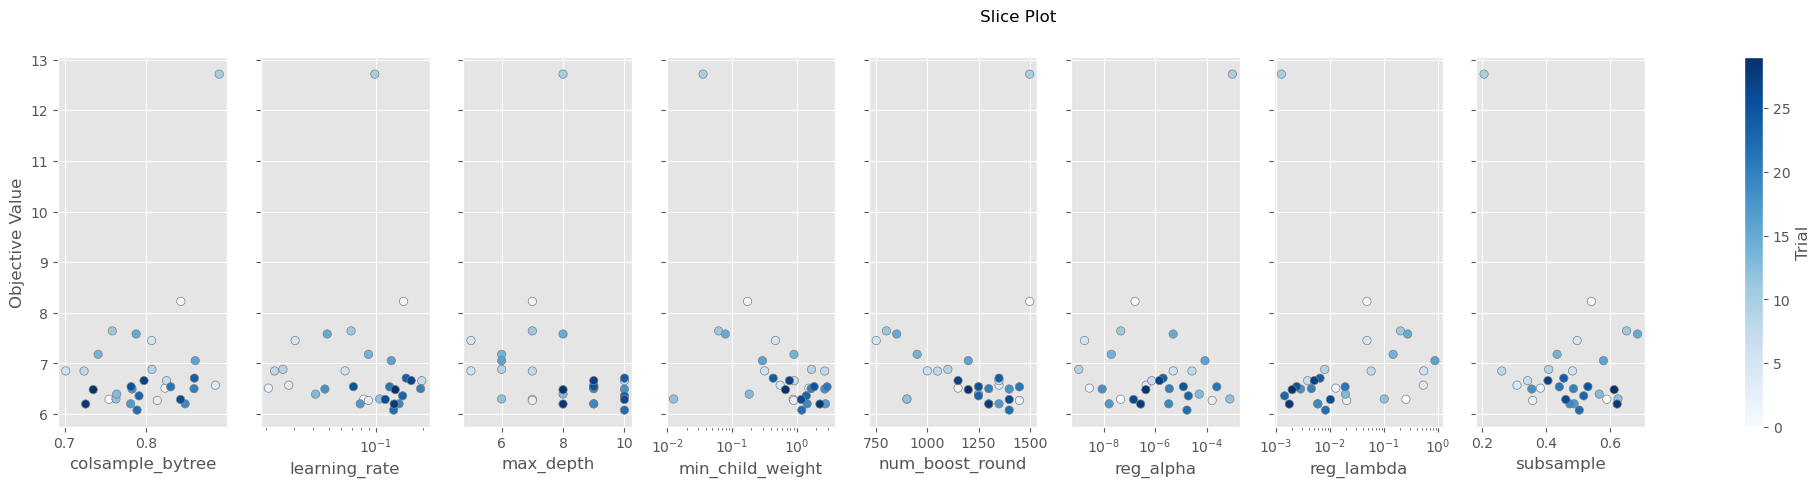

In [35]:
from optuna.visualization.matplotlib import plot_slice
import matplotlib.pyplot as plt

ax  = plot_slice(best_study)
plt.show()

In [36]:
print(f"\n10-fold nested-CV NLL: {np.mean(nll_outer):.4f} ± {np.std(nll_outer):.4f}")
print(f"10-fold nested-CV Full C-index: {np.nanmean(c_index_outer):.4f} ± {np.nanstd(c_index_outer):.4f}")
print(f"10-fold nested-CV RMSE: {np.nanmean(rmse_log10_outer):.4f} ± {np.nanstd(rmse_log10_outer):.4f}")

print(f"10-fold nested-CV Uncensored C-index: {np.nanmean(c_index_outer_uncensored):.4f} ± {np.nanstd(c_index_outer_uncensored):.4f}")
print(f"10-fold nested-CV Uncensored Spearman P-score: {np.nanmean(spearman_outer_uncensored):.4f} ± {np.nanstd(spearman_outer_uncensored):.4f}")
print(f"10-fold nested-CV Share Of Censored Which Predict < Cap of 3600s: {np.nanmean(share_censored_predicted_lower_lb_outer):.4f} ± {np.nanstd(share_censored_predicted_lower_lb_outer):.4f}")

print(f"10-fold nested-CV Precision: {np.nanmean(precision_outer):.4f} ± {np.nanstd(precision_outer):.4f}")
print(f"10-fold nested-CV Recall: {np.nanmean(recall_outer):.4f} ± {np.nanstd(recall_outer):.4f}")


print("Best params")
for k, v in best_study.best_params.items():
    print(f"  {k}: {v:.4}" if isinstance(v, float) else f"  {k}: {v}")


10-fold nested-CV NLL: 5.5562 ± 0.5952
10-fold nested-CV Full C-index: 0.7970 ± 0.0309
10-fold nested-CV RMSE: 1.0576 ± 0.1253
10-fold nested-CV Uncensored C-index: 0.7682 ± 0.0278
10-fold nested-CV Uncensored Spearman P-score: 0.7081 ± 0.0583
10-fold nested-CV Share Of Censored Which Predict < Cap of 3600s: 0.6791 ± 0.0774
10-fold nested-CV Precision: 0.7682 ± 0.1393
10-fold nested-CV Recall: 0.3209 ± 0.0774
Best params
  num_boost_round: 1400
  learning_rate: 0.1298
  max_depth: 10
  min_child_weight: 1.197
  subsample: 0.504
  colsample_bytree: 0.7888
  reg_alpha: 1.728e-05
  reg_lambda: 0.00827


In [37]:
oof_true_log = np.concatenate(oof_true_log)
oof_pred_log = np.concatenate(oof_pred_log)

fig_dir = RUN_DIR / "figs"
plot_calibration_on_solved_cases(
    oof_true_log, oof_pred_log,
    save_path=fig_dir / "calibration_scatter_oof.png", # oof means out of fold
    show=False,
    lower=1e-4, upper=1e4,
    title="XGBoost ATF"
)

plot_aggregated_learning_curves(
    nll_histories_all,
    cidx_histories_all,
    save_path=fig_dir / "learning_curves_aggregated.png",
    show=False
)

In [38]:
dall = xgb.DMatrix(X)
dall.set_float_info("label_lower_bound", y_lb)
dall.set_float_info("label_upper_bound", y_ub)

final_params = best_params | {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
}

num_round = best_num_round
best_booster = xgb.train(final_params, dall, num_boost_round=num_round)
best_booster.save_model(RUN_DIR / "model" / "runtime_xgb_aft_full.json")

metrics_summary = {
    "nll_outer_mean":                      nll_outer,
    "nll_outer_std":                       nll_outer,
    "c_index_outer_mean":                  c_index_outer,
    "c_index_outer_std":                   c_index_outer,
    "c_index_outer_uncensored_mean":       c_index_outer_uncensored,
    "c_index_outer_uncensored_std":        c_index_outer_uncensored,
    "spearman_outer_uncensored_mean":      spearman_outer_uncensored,
    "spearman_outer_uncensored_std":       spearman_outer_uncensored,
    "rmse_log10_outer_mean":               rmse_log10_outer,
    "rmse_log10_outer_std":                rmse_log10_outer,
    "share_cens_pred_below_lb_mean":       share_censored_predicted_lower_lb_outer,
    "share_cens_pred_below_lb_std":        share_censored_predicted_lower_lb_outer,
    "precision_timeout_mean":              precision_outer,
    "precision_timeout_std":               precision_outer,
    "recall_timeout_mean":                 recall_outer,
    "recall_timeout_std":                  recall_outer,
    # per-fold detail
    "best_fold_idx":                       int(best_fold_idx) if best_fold_idx is not None else None,
    "best_nll":                            float(best_nll) if np.isfinite(best_nll) else None,
    "best_num_round":                      int(best_num_round) if best_num_round is not None else None,
}
save_metrics("survival_nested_cv_summary", metrics_summary)
save_optuna(best_booster)